In [2]:
import torch 
torch.cuda.is_available()

False

In [3]:
import torch.nn as nn 
print(nn.functional.conv2d) 

<built-in method conv2d of type object at 0x00007FF9B1C1EE80>


In [4]:
import torch

print(torch.cuda.is_available())
print(torch.__version__)
print(torch.version.cuda)

False
2.4.0+cpu
None


https://mirrors.tuna.tsinghua.edu.cn/anaconda/pkgs/main/win-64/cudatoolkit-9.0-1.tar.bz2

pip install torch==1.13.1+cu116 torchvision==0.14.1+cu116 torchaudio==0.13.1 -f https://download.pytorch.org/whl/torch_stable.html

pip install torchvision==0.14.1+cu116 torchaudio==0.13.1 -f https://download.pytorch.org/whl/torch_stable.html

https://mirrors.aliyun.com/pytorch-wheels/cu116/

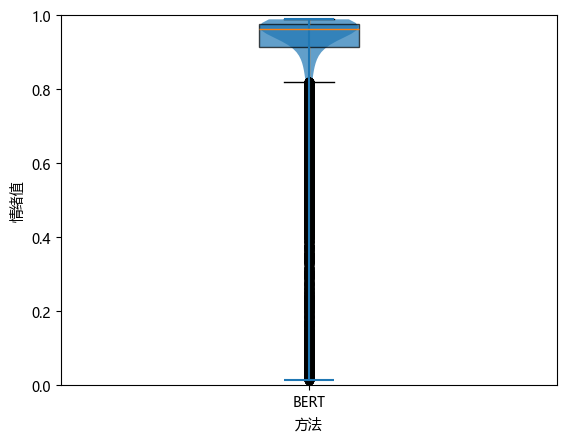

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

df_origin = pd.read_csv('20200201_20200301 27808 条2.4万条.csv')

fig, ax = plt.subplots()
box_positions = [0.5 - 0.1, 0.5+ 0.1]  # 调整位置，使两个箱线图并排显示
box_width = 0.2

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']

# 绘制箱线图
box1 = ax.boxplot(df_origin['ad_prob'], widths=box_width, patch_artist=True,
                  boxprops=dict(facecolor='#1f77b4', alpha=0.7),
                  medianprops=dict(color='#ff7f0e'),  # 设置中位数线的颜色
                  whiskerprops=dict(color='#ff7f0e'))  # 设置须的颜色
# box2 = ax.boxplot(data['snownlp+emoji'], positions=[box_positions[1]], widths=box_width, patch_artist=True,
#                   boxprops=dict(facecolor='#ff7f0e', alpha=0.7),
#                   medianprops=dict(color='#1f77b4'),  # 设置中位数线的颜色
#                   whiskerprops=dict(color='#1f77b4'))  # 设置须的颜色

# 绘制琴谱图
violin1 = ax.violinplot(df_origin['ad_prob'], widths=box_width, showmedians=False)
# violin2 = ax.violinplot(data['snownlp+emoji'], positions=[box_positions[1]], widths=box_width, showmedians=False)

# 设置琴谱图的颜色和透明度
for violin, color in zip([violin1], ['#1f77b4', '#ff7f0e']):
    for pc in violin['bodies']:
        pc.set_facecolor(color)
        pc.set_alpha(0.7)

# 设置 x 轴标签
# ax.set_xticks([0.5])
ax.set_xticklabels(['BERT'])

# 设置标题和轴标签
# ax.set_title('SnowNLP加emoji')
ax.set_xlabel('方法')
ax.set_ylabel('情绪值')
ax.set_ylim(0, 1)

plt.show()


In [2]:
df_origin['pred'].value_counts()

pred
1    24425
0     1665
Name: count, dtype: int64

In [2]:
# 大于0.7的概率的个数为： 18064
# 0.3~0.7的概率的个数为： 5769
# 小于0.3的概率的个数为： 2257
# 把上述三个值赋值给wp,wz,wn
wp = 18064
wz = 5769
wn = 2257

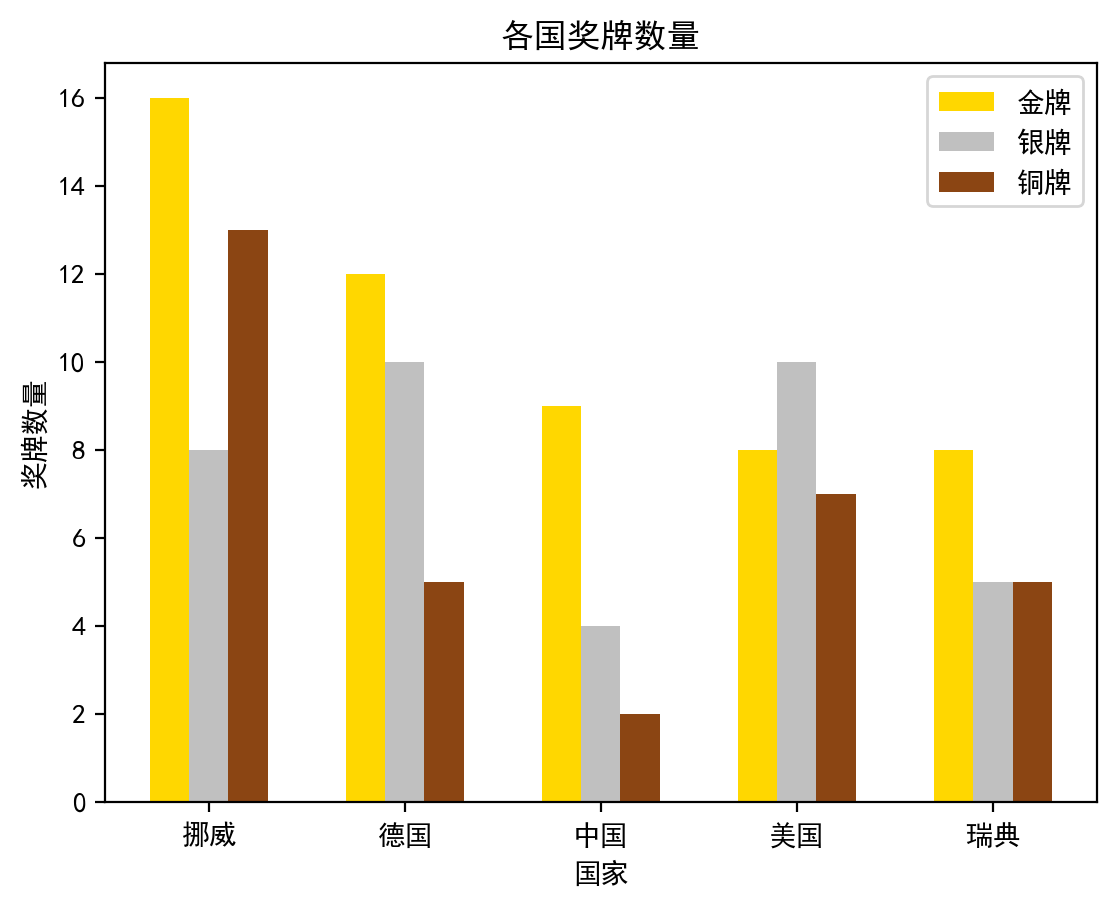

In [7]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.figure(dpi=200)

countries = ['挪威', '德国', '中国', '美国', '瑞典']
gold_medal = [16, 12, 9, 8, 8]
silver_medal = [8, 10, 4, 10, 5]
bronze_medal = [13, 5, 2, 7, 5]

# 创建一个数组来表示每个国家的位置
x = np.arange(len(countries))
width = 0.2

# 计算每种奖牌的位置
gold_x = x
silver_x = x + width
bronze_x = x + 2 * width

# 绘制柱状图
plt.bar(gold_x, gold_medal, width=width, color="gold", label='金牌')
plt.bar(silver_x, silver_medal, width=width, color="silver", label='银牌')
plt.bar(bronze_x, bronze_medal, width=width, color="saddlebrown", label='铜牌')

# 设置x轴标签
plt.xticks(x + width, countries)

# 添加标题和标签
plt.title('各国奖牌数量')
plt.xlabel('国家')
plt.ylabel('奖牌数量')

# 添加图例
plt.legend()

# 显示图形
plt.show()


In [ ]:
import re
import torch
import pandas as pd
import numpy as np
import psutil
from pandarallel import pandarallel
from transformers import BertForSequenceClassification, BertTokenizer, BertConfig, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from tqdm import trange, tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

def clean_content(content):
    import re    
    # 去除一些关键词
    content =content.replace('分享图片', '').replace('分享视频', '').replace('微博视频', '').replace('的微博视频', '').replace('网页链接','').replace('超话','').replace('br','')
    # 去除两个#和他们之间的文字
    content = re.sub(r'#.*#', '', content)
    # 去除@和他们之间的文字
    content = re.sub(r'@.*@', '', content)
    # 去除[]和他们之间的文字
    content = re.sub(r'\[.*?\]', '', content)
    # 保留表情符号，去除其他符号
    content = re.sub(r'[^\w\s\u4e00-\u9fa5\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F700-\U0001F77F\U0001F780-\U0001F7FF\U0001F800-\U0001F8FF\U0001F900-\U0001F9FF\U0001FA00-\U0001FA6F\U0001FA70-\U0001FAFF\U00002702-\U000027B0]', '', content)
    # 去除英文
    content = re.sub(r'[a-zA-Z]+', '', content)
    content = re.sub(r'\d+', '', content).replace(' ', '').replace('.', '').replace('_','')
    return content

# 定义分词函数
def get_tokens(text, tokenizer, max_seq_length, add_special_tokens=True):
    input_ids = tokenizer.encode(text, add_special_tokens=add_special_tokens, truncation=True, max_length=max_seq_length, pad_to_max_length=True)
    attention_mask = [int(id > 0) for id in input_ids]
    assert len(input_ids) == max_seq_length
    assert len(attention_mask) == max_seq_length
    return (input_ids, attention_mask)

if __name__=='__main__':
    # 初始化pandarallel
    pandarallel.initialize(nb_workers=psutil.cpu_count(logical=False))

    # 读取数据
    df_label = pd.read_csv('weibo_label.csv')

    # 读取emoji
    emoji_label=pd.read_csv('emoji_label.csv')

    # 清洗数据
    df_label['message'] = df_label['message'].parallel_apply(clean_content)


    # 去除空的行 
    df_label= df_label[df_label['message'] != '']

    # 数据预处理
    df_label.sentiment.value_counts()
    df = df_label.copy()
    df.loc[df[df.sentiment!=6].index,'sentiment'] = 1
    df = df[(df['sentiment']==1) | (df['sentiment']==6)]
    drop_size = len(df[df['sentiment']==1].sentiment) - len(df[df['sentiment']==6].sentiment)
    df.drop(df[df['sentiment']==1].sample(drop_size).index, inplace=True)
    df.loc[df[df.sentiment==6].index,'sentiment'] = 0
    
    # 把emoji_label加入到df_label
    df = pd.concat([df, emoji_label], axis=0)
    
    print(df.sentiment.unique())
    print(df)

In [ ]:
df.to_csv('hah.csv',index=False,encoding='utf-8-sig')

In [7]:
df['sentiment'].value_counts()

sentiment
0    6479
1    5939
Name: count, dtype: int64

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

name1 = '20200201_20200301 27808 条1万条.csv'
name2 = '20200201_20200301 27808 条2.4万条.csv'
name3 = '20200301_20200401 38709 条2.4万条.csv'

df_origin1 = pd.read_csv(name1)
df_origin2 = pd.read_csv(name2)
df_origin3 = pd.read_csv(name3)

name_total = [name1, name2, name3]
df_origin_total = [df_origin1, df_origin2, df_origin3]

plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签

for i, df_origin in enumerate(df_origin_total):
    name = name_total[i]
    
    # 将publish_time列转换为datetime类型
    df_origin['publish_time'] = pd.to_datetime(df_origin['publish_time'])

    # 根据ad_prob值进行分类
    def classify_ad_prob(value):
        if value > 0.6:
            return '积极'
        elif value < 0.4:
            return '消极'
        else:
            return '中立'

    df_origin['ad_prob_class'] = df_origin['ad_prob'].apply(classify_ad_prob)

    # 1. 一天24小时的柱状图
    df_origin['hour'] = df_origin['publish_time'].dt.hour
    hourly_counts = df_origin.groupby(['hour', 'ad_prob_class']).size().unstack(fill_value=0)

    hourly_counts.plot(kind='bar', stacked=True, figsize=(12, 6))
    plt.title(name+'一天24小时ad_prob分类柱状图')
    plt.xlabel('小时')
    plt.ylabel('数量')
    plt.legend(title='分类')
    plt.show()

    # 2. 31天的柱状图
    df_origin['day'] = df_origin['publish_time'].dt.day
    daily_counts = df_origin.groupby(['day', 'ad_prob_class']).size().unstack(fill_value=0)

    daily_counts.plot(kind='bar', stacked=True, figsize=(12, 6))
    plt.title(name+'31天ad_prob分类柱状图')
    plt.xlabel('天')
    plt.ylabel('数量')
    plt.legend(title='分类')
    plt.show()


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

name1 = '20200201_20200301 27808 条1万条.csv'
name2 = '20200201_20200301 27808 条2.4万条.csv'
name3 = '20200301_20200401 38709 条2.4万条.csv'

df_origin1 = pd.read_csv(name1)
df_origin2 = pd.read_csv(name2)
df_origin3 = pd.read_csv(name3)

name_total = [name1, name2, name3]
df_origin_total = [df_origin1, df_origin2, df_origin3]

plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签

for i, df_origin in enumerate(df_origin_total):
    name = name_total[i]
    
    # 将publish_time列转换为datetime类型
    df_origin['publish_time'] = pd.to_datetime(df_origin['publish_time'])

    # 1. 这个月的一天24小时的ad_prob列的值的箱线图
    # 按小时分组
    df_origin['hour'] = df_origin['publish_time'].dt.hour
    hourly_ad_prob = df_origin.groupby('hour')['ad_prob'].apply(list)

    plt.figure(figsize=(12, 6), dpi=200)
    plt.boxplot(hourly_ad_prob.values, labels=hourly_ad_prob.index)
    plt.title(name + ' 24小时情绪值箱线图')
    plt.xlabel('小时')
    plt.ylabel('ad_prob')
    plt.ylim(0, 1)
    plt.show()

    # 2. 这个月31天每天的ad_prob列的值的箱线图
    # 按天分组
    df_origin['day'] = df_origin['publish_time'].dt.day
    daily_ad_prob = df_origin.groupby('day')['ad_prob'].apply(list)

    plt.figure(figsize=(12, 6), dpi=200)
    plt.boxplot(daily_ad_prob.values, labels=daily_ad_prob.index)
    plt.title(name + ' 31天情绪值箱线图')
    plt.xlabel('天')
    plt.ylabel('ad_prob')
    plt.ylim(0, 1)
    plt.show()


51038
50967


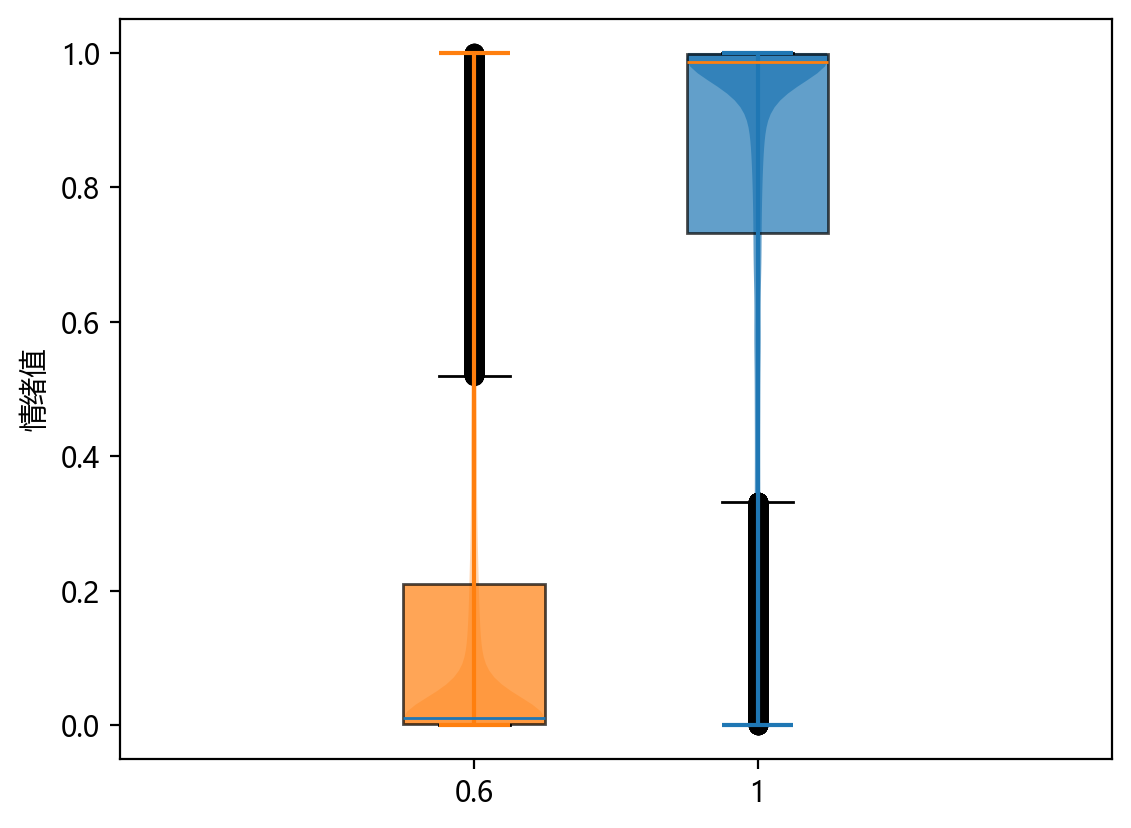

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']

df_origin=pd.read_csv('data\WeiboTrainData\sentiment_analysis_data(AliNLP)_2024-07-06_(Run_144m).csv')
print(len(df_origin))
df_origin.dropna(subset=['ali_positive'],inplace=True)
print(len(df_origin))
df_origin.sample(5)

fig, ax = plt.subplots(dpi=200)
box_positions = [0.5 - 0.1, 0.5+ 0.1]  # 调整位置，使两个箱线图并排显示
box_width = 0.2

# 设置中文字体

# 绘制箱线图
box1 = ax.boxplot(df_origin['ali_positive'], widths=box_width, patch_artist=True,
                  boxprops=dict(facecolor='#1f77b4', alpha=0.7),
                  medianprops=dict(color='#ff7f0e'),  # 设置中位数线的颜色
                  whiskerprops=dict(color='#ff7f0e'))  # 设置须的颜色
box2 = ax.boxplot(df_origin['ali_negative'], positions=[box_positions[1]], widths=box_width, patch_artist=True,
                  boxprops=dict(facecolor='#ff7f0e', alpha=0.7),
                  medianprops=dict(color='#1f77b4'),  # 设置中位数线的颜色
                  whiskerprops=dict(color='#1f77b4'))  # 设置须的颜色

# 绘制琴谱图
violin1 = ax.violinplot(df_origin['ali_positive'],widths=box_width, showmedians=False)
violin2 = ax.violinplot(df_origin['ali_negative'], positions=[box_positions[1]], widths=box_width, showmedians=False)

# 设置琴谱图的颜色和透明度
for violin, color in zip([violin1], ['#1f77b4', '#ff7f0e']):
    for pc in violin['bodies']:
        pc.set_facecolor(color)
        pc.set_alpha(0.7)

# 设置 x 轴标签
# ax.set_xticks([0.5])
# ax.set_xticklabels(['积极','消极'])

# 设置标题和轴标签
# ax.set_title('SnowNLP加emoji')
# ax.set_xlabel('方法')
ax.set_ylabel('情绪值')

plt.show()


In [4]:
import pandas as pd

baidu = "data/上海2019_2023年按月分类文件_情绪值/20190301_20190401 26184 条_Baidu.csv"
tencent = "data/上海2019_2023年按月分类文件_情绪值/20190301_20190401 26184 条_Tencent.csv"

baidu_df = pd.read_csv(baidu, encoding='utf-8-sig')
tencent_df = pd.read_csv(tencent, encoding='utf-8-sig')

# 确保 tencent_df 中有这些列
required_columns = ['Tencent_positive', 'Tencent_neutral', 'Tencent_negative', 'Tencent_sentiment']
if not all(col in tencent_df.columns for col in required_columns):
    raise KeyError(f"Tencent DataFrame 缺少必要的列: {required_columns}")

# 循环百度的数据 依据content列找到腾讯对应的数据 将data['Tecent_positive'], data['Tencent_neutral'], data['Tecent_negative'], data['Tencent_sentiment']  添加到百度数据的列
for index, data in baidu_df.iterrows():
    content = data['content']
    tencent_data = tencent_df[tencent_df['content'] == content]
    if not tencent_data.empty:
        baidu_df.loc[index, 'Tencent_positive'] = tencent_data['Tencent_positive'].values[0]
        baidu_df.loc[index, 'Tencent_neutral'] = tencent_data['Tencent_neutral'].values[0]
        baidu_df.loc[index, 'Tencent_negative'] = tencent_data['Tencent_negative'].values[0]
        baidu_df.loc[index, 'Tencent_sentiment'] = tencent_data['Tencent_sentiment'].values[0]

baidu_df.to_csv('data/baidu_tencent_sentiment.csv', index=False, encoding='utf-8-sig')


In [5]:
print(len(baidu_df))
baidu_df.dropna(subset=['Tencent_positive'],inplace=True)
baidu_df.to_csv('data/baidu_tencent_sentiment.csv', index=False, encoding='utf-8-sig')
print(len(baidu_df))

22604
21747


In [13]:
import pandas as pd 
import re

data=pd.read_csv('data/WeiboTrainData/weibo_senti_100k.csv')    
# data.columns=['mid','message','sentiment']
data.columns=['label','review']
def clean_content(content):
    # 去除一些关键词
    content =content.replace('分享图片', '').replace('分享视频', '').replace('微博视频', '').replace('的微博视频', '').replace('网页链接','').replace('超话','').replace('新浪图片','').replace('<br>','')    
    # 去除英文
    content = re.sub(r'[a-zA-Z]+', '', content)
    content = re.sub(r'\d+', '', content).replace(' ', '').replace('.', '').replace('_','')
    # 去除所有非中文符号
    content = re.sub(r'[^\u4e00-\u9fa5]', '', content)
    # 去除空白字符
    content = re.sub(r'\s+', '', content)
    return content
data['clean_content']=data.apply(lambda row: clean_content(row['review']),axis=1)
data.to_csv('data\WeiboTrainData\weibo_senti_100k.csv',index=False,encoding='utf-8-sig')
data.head()

label                                             review  \
0      1              ﻿更博了，爆照了，帅的呀，就是越来越爱你！生快傻缺[爱你][爱你][爱你]   
1      1  @张晓鹏jonathan 土耳其的事要认真对待[哈哈]，否则直接开除。@丁丁看世界 很是细心...   
2      1  姑娘都羡慕你呢…还有招财猫高兴……//@爱在蔓延-JC:[哈哈]小学徒一枚，等着明天见您呢/...   
3      1                                         美~~~~~[爱你]   
4      1                                  梦想有多大，舞台就有多大![鼓掌]   

                                clean_content  
0                  更博了爆照了帅的呀就是越来越爱你生快傻缺爱你爱你爱你  
1        张晓鹏土耳其的事要认真对待哈哈否则直接开除丁丁看世界很是细心酒店都全部啦  
2  姑娘都羡慕你呢还有招财猫高兴爱在蔓延哈哈小学徒一枚等着明天见您呢李欣芸大佬范儿书呆子  
3                                         美爱你  
4                               梦想有多大舞台就有多大鼓掌

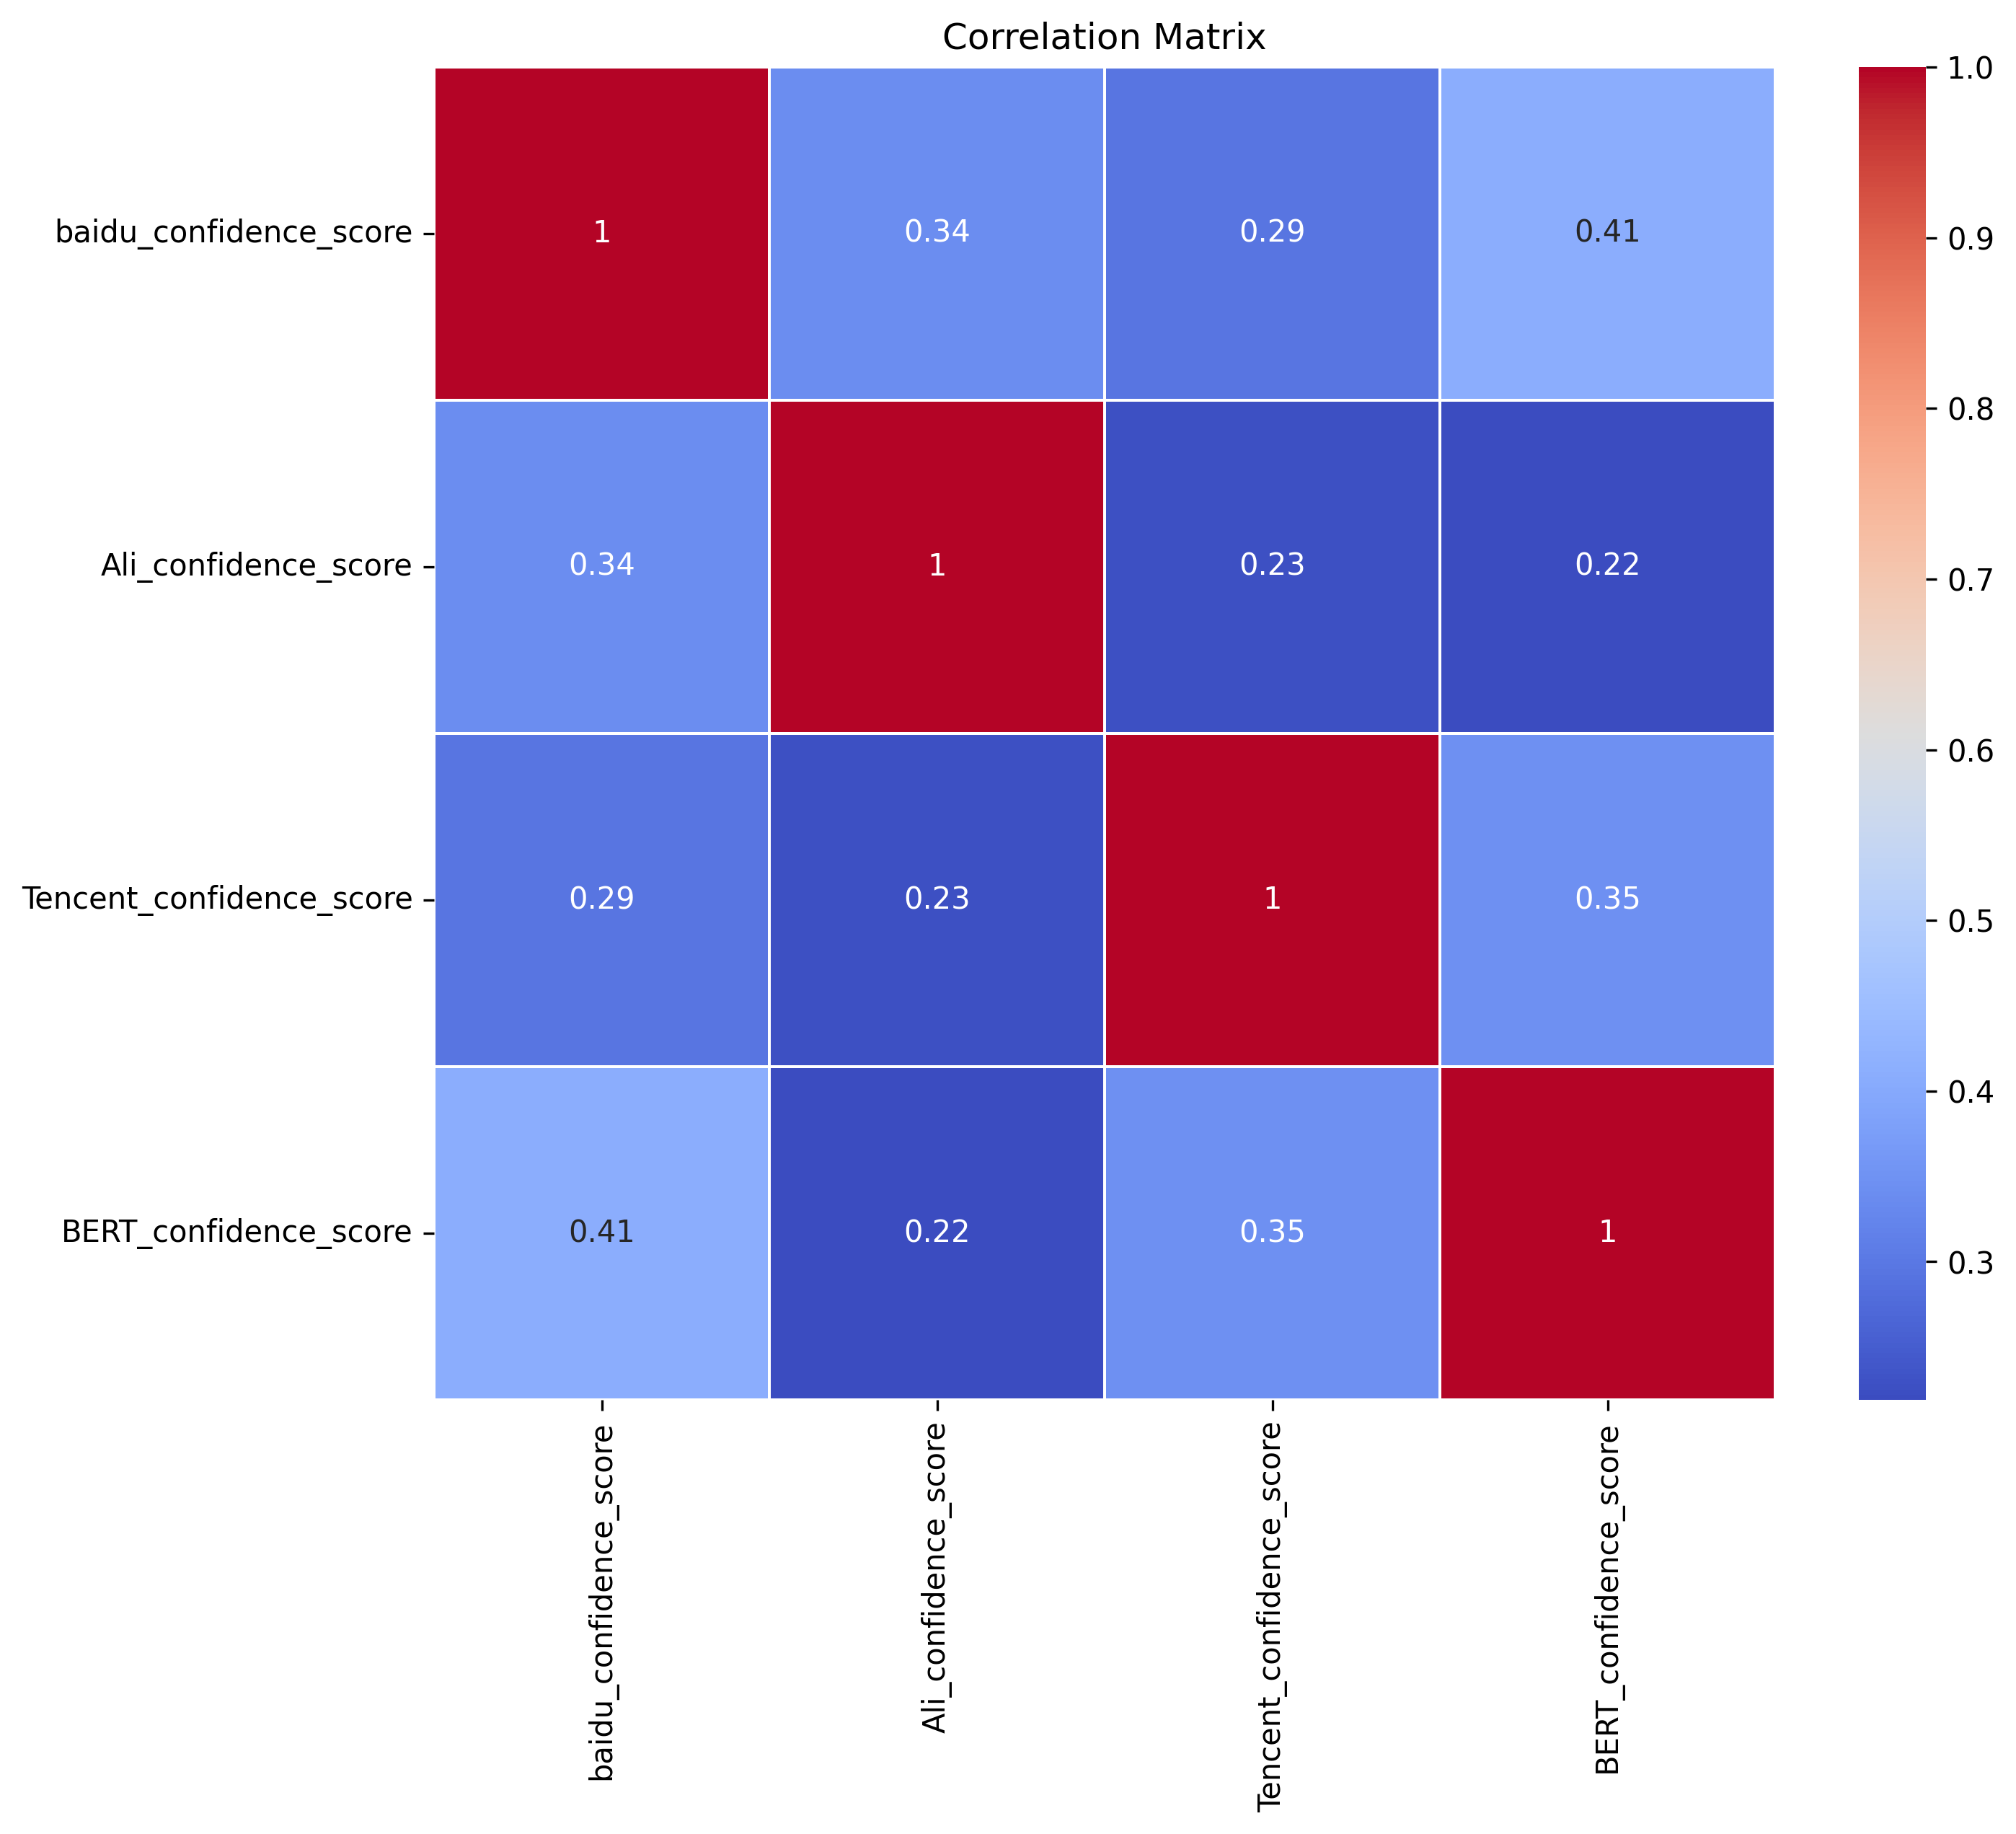

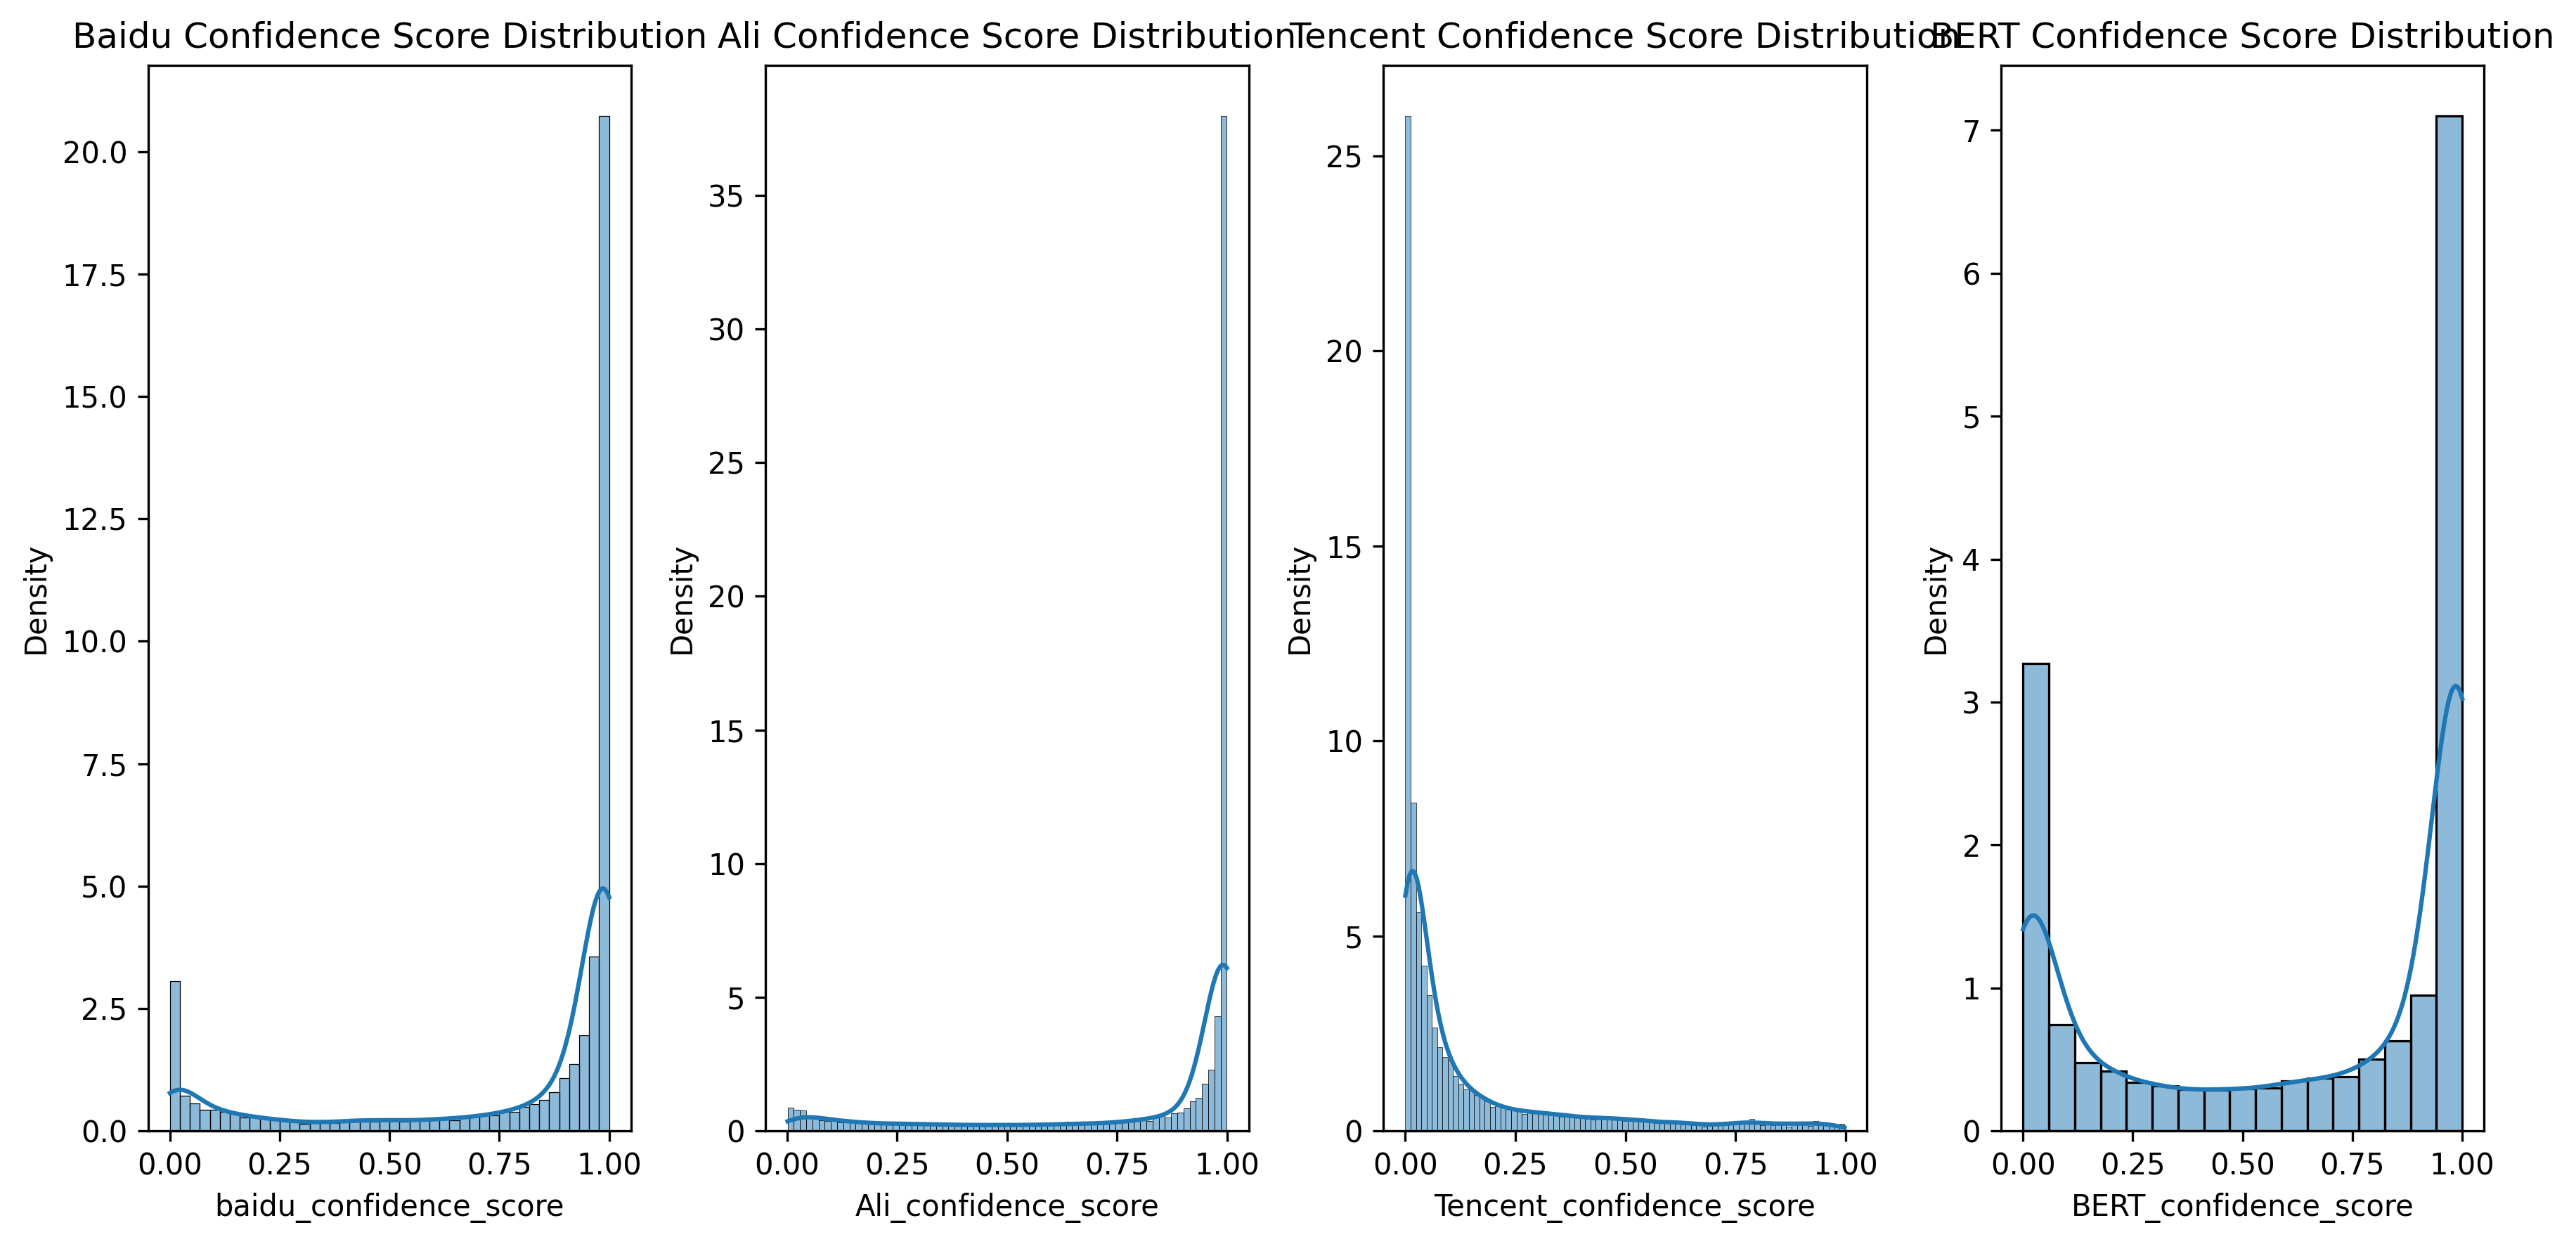

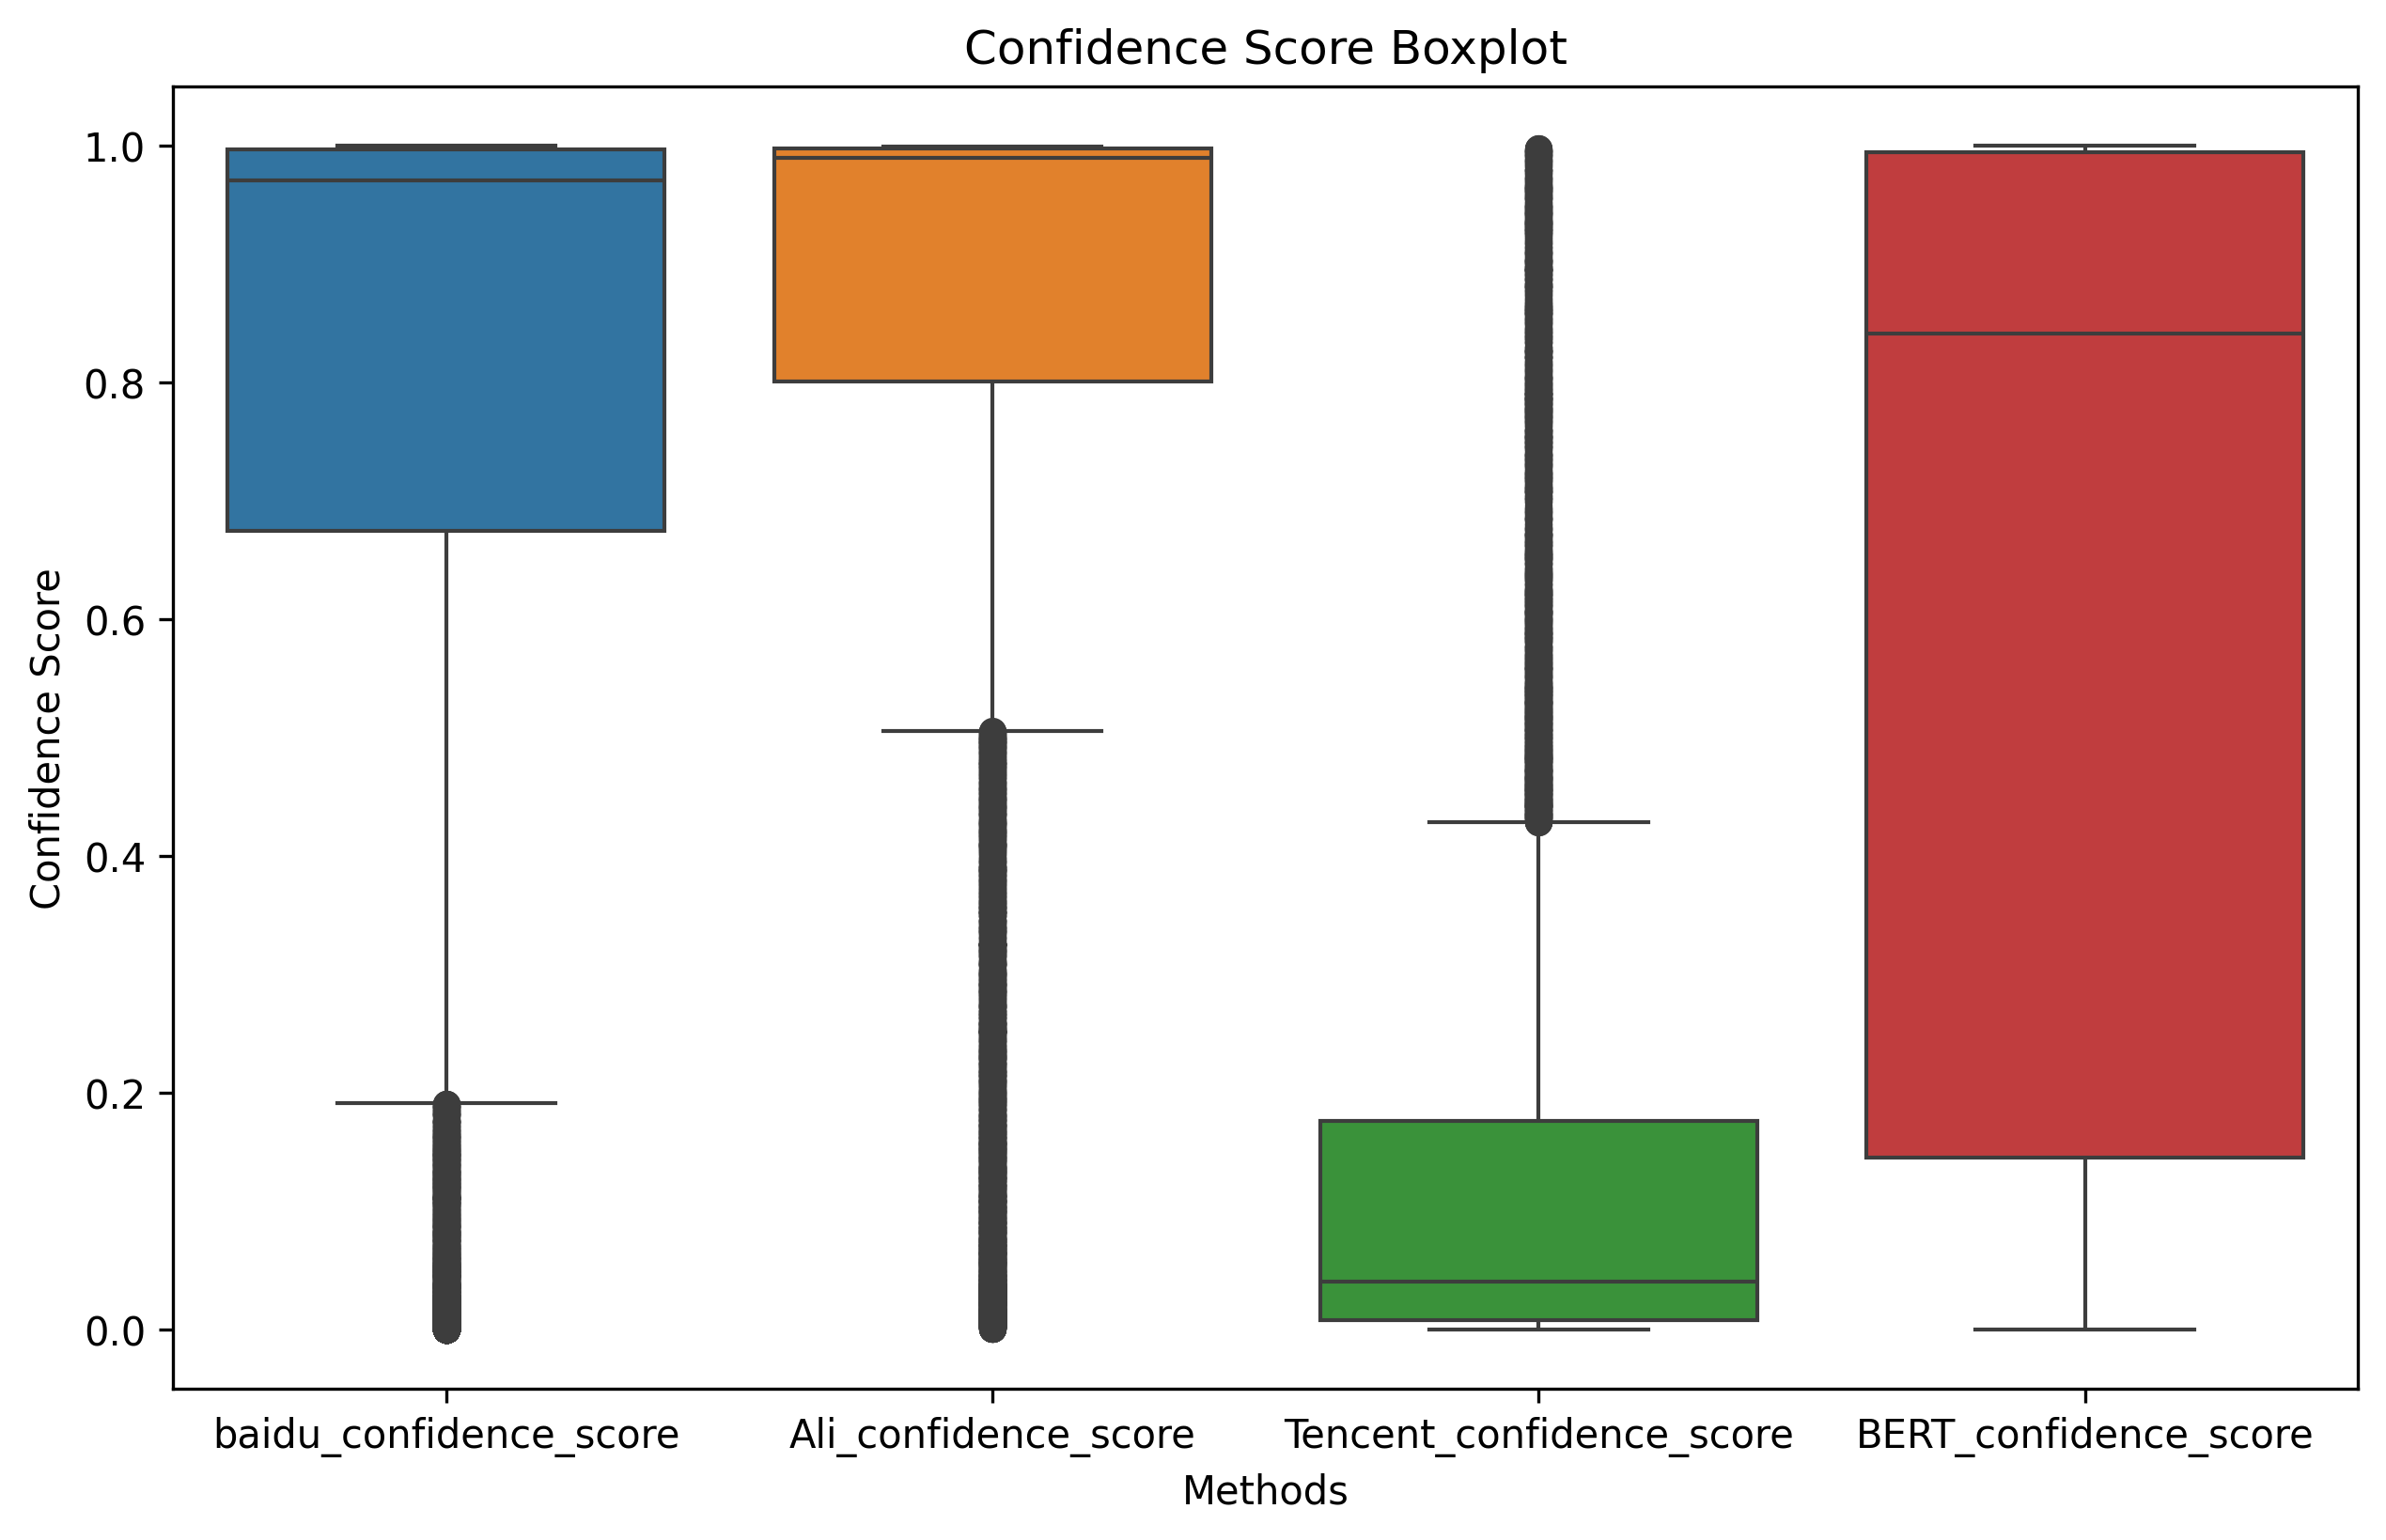

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 假设数据已经读取到一个DataFrame中，名为df
# data = {
#     'baidu_confidence': [0.974418, 0.883366, 0.75305, 0.967932, 0.903323, 0.999889, 0.98779, 0.608935, 0.21613, 0.892242],
#     'baidu_negative': [0.0115121, 0.0524851, 0.888873, 0.985569, 0.0435048, 4.98E-05, 0.00549455, 0.824021, 0.352741, 0.0484912],
#     'baidu_positive': [0.988488, 0.947515, 0.111128, 0.0144308, 0.956495, 0.99995, 0.994505, 0.175979, 0.647259, 0.951509],
#     'baidu_sentiment': [2, 2, 0, 0, 2, 2, 2, 0, 2, 2],
#     'Tencent_positive': [0.654513121, 0.008661079, 0.031652123, 0.001442806, 0.012902087, 0.076046325, 0.227823943, 0.004762241, 0.003330068, 0.001393137],
#     'Tencent_neutral': [0.33094421, 0.971560061, 0.955590367, 0.948951304, 0.77349025, 0.797024608, 0.755045593, 0.764150023, 0.984782279, 0.993173778],
#     'Tencent_negative': [0.014542675, 0.019778911, 0.012757527, 0.049605865, 0.213607579, 0.126929134, 0.017130449, 0.231087819, 0.011887722, 0.00543305],
#     'Tencent_sentiment': ['positive', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral'],
#     'BERT_ad_prob': [0.998641193, 0.534058154, 0.456146657, 0.681231856, 0.990154088, 0.373545289, 0.884301722, 0.94806391, 0.035365317, 0.007322421],
#     'BERT_pred': [1, 1, 0, 1, 1, 0, 1, 1, 0, 0]
# }
import pandas as pd

data=pd.read_csv(r'data\上海2019_2023年按月分类文件_情绪值\对比验证\20190301_20190401 26184 条_Baidu&Tencent&BERT&Ali 21747 条.csv')
# data.head()

df = pd.DataFrame(data)

# 情感标签转换为数值
df['Tencent_sentiment'] = df['Tencent_sentiment'].map({'positive': 1, 'neutral': 0, 'negative': -1})

# 计算置信度
df['baidu_confidence_score'] = df['baidu_positive']
df['Tencent_confidence_score'] = df['Tencent_positive']
df['Ali_confidence_score']=df['ali_positive']
df['BERT_confidence_score'] = df['BERT_ad_prob']

# 计算相关性
correlation_matrix = df[['baidu_confidence_score', 'Ali_confidence_score','Tencent_confidence_score', 'BERT_confidence_score']].corr()

# 绘制相关性矩阵图
plt.figure(figsize=(10, 8),dpi=300)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

# 绘制置信度分布图
plt.figure(figsize=(12, 6),dpi=300)
plt.subplot(1, 4, 1)
# sns.histplot(df['baidu_confidence_score'], kde=True)
sns.histplot(df['baidu_confidence_score'], kde=True,stat='density')
plt.title('Baidu Confidence Score Distribution')

plt.subplot(1, 4, 2)
# sns.histplot(df['Ali_confidence_score'], kde=True)
sns.histplot(df['Ali_confidence_score'], kde=True,stat='density')
plt.title('Ali Confidence Score Distribution')

plt.subplot(1, 4, 3)
# sns.histplot(df['Tencent_confidence_score'], kde=True)
sns.histplot(df['Tencent_confidence_score'], kde=True,stat='density')
plt.title('Tencent Confidence Score Distribution')

plt.subplot(1, 4, 4)
# sns.histplot(df['BERT_confidence_score'], kde=True)
sns.histplot(df['BERT_confidence_score'], kde=True,stat='density')
plt.title('BERT Confidence Score Distribution')

plt.tight_layout()
plt.show()

# 绘制箱线图
plt.figure(figsize=(10, 6),dpi=300)
sns.boxplot(data=df[['baidu_confidence_score', 'Ali_confidence_score','Tencent_confidence_score', 'BERT_confidence_score']])
plt.title('Confidence Score Boxplot')
plt.xlabel('Methods')
plt.ylabel('Confidence Score')
plt.show()

#Method 1 Method 2  T-test Statistic       P-value
# 0     Baidu      Ali        -15.737973  1.190373e-55
# 1     Baidu  Tencent        221.149863  0.000000e+00
# 2     Baidu     BERT         41.353379  0.000000e+00
# 3       Ali    Baidu         15.737973  1.190373e-55
# 4       Ali  Tencent        259.705718  0.000000e+00
# 5       Ali     BERT         57.717950  0.000000e+00
# 6   Tencent    Baidu       -221.149863  0.000000e+00
# 7   Tencent      Ali       -259.705718  0.000000e+00
# 8   Tencent     BERT       -149.231260  0.000000e+00
# 9      BERT    Baidu        -41.353379  0.000000e+00
# 10     BERT      Ali        -57.717950  0.000000e+00
# 11     BERT  Tencent        149.231260  0.000000e+00


20190101
20190201
20190301
20190401
20190501
20190601
20190701
20190801
20190901
20191001
20191101
20191201
20200101
20200201
20200301
20200401
20200501
20200601
20210101
20210201
20210301
20210401
20210501
20210601
20210701
20210801
20210901
20211001
20211101
20211201
20220101
20220201
20220301
20220401


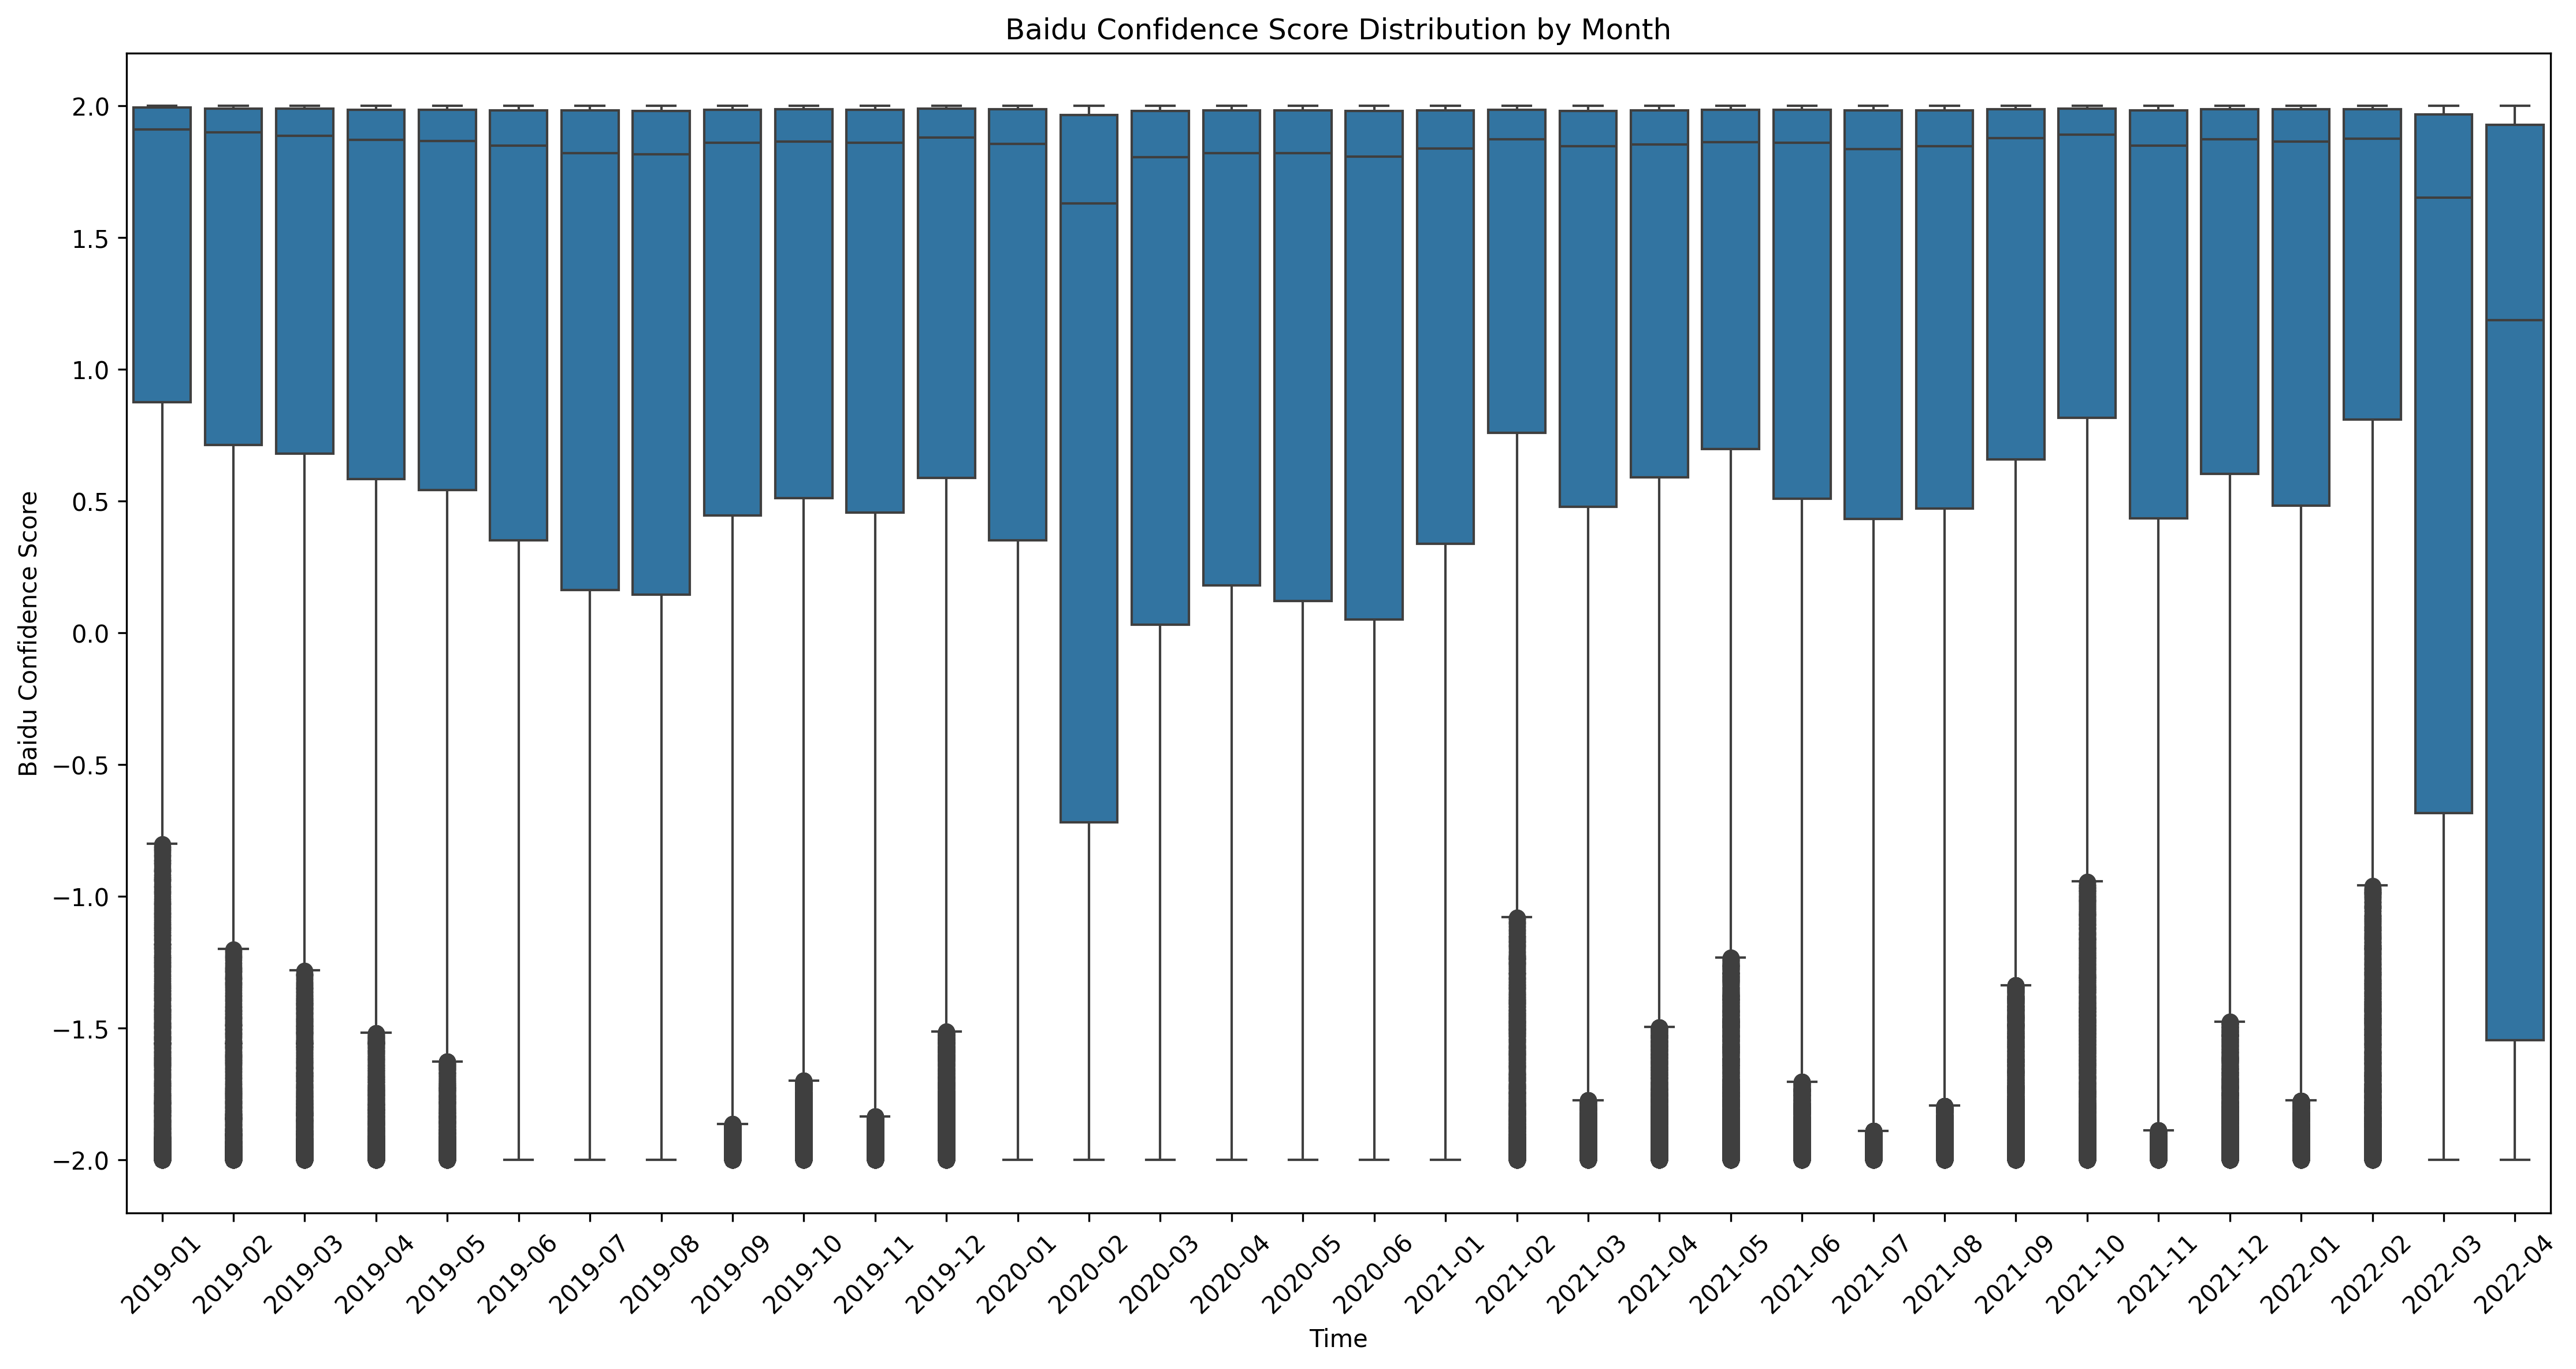

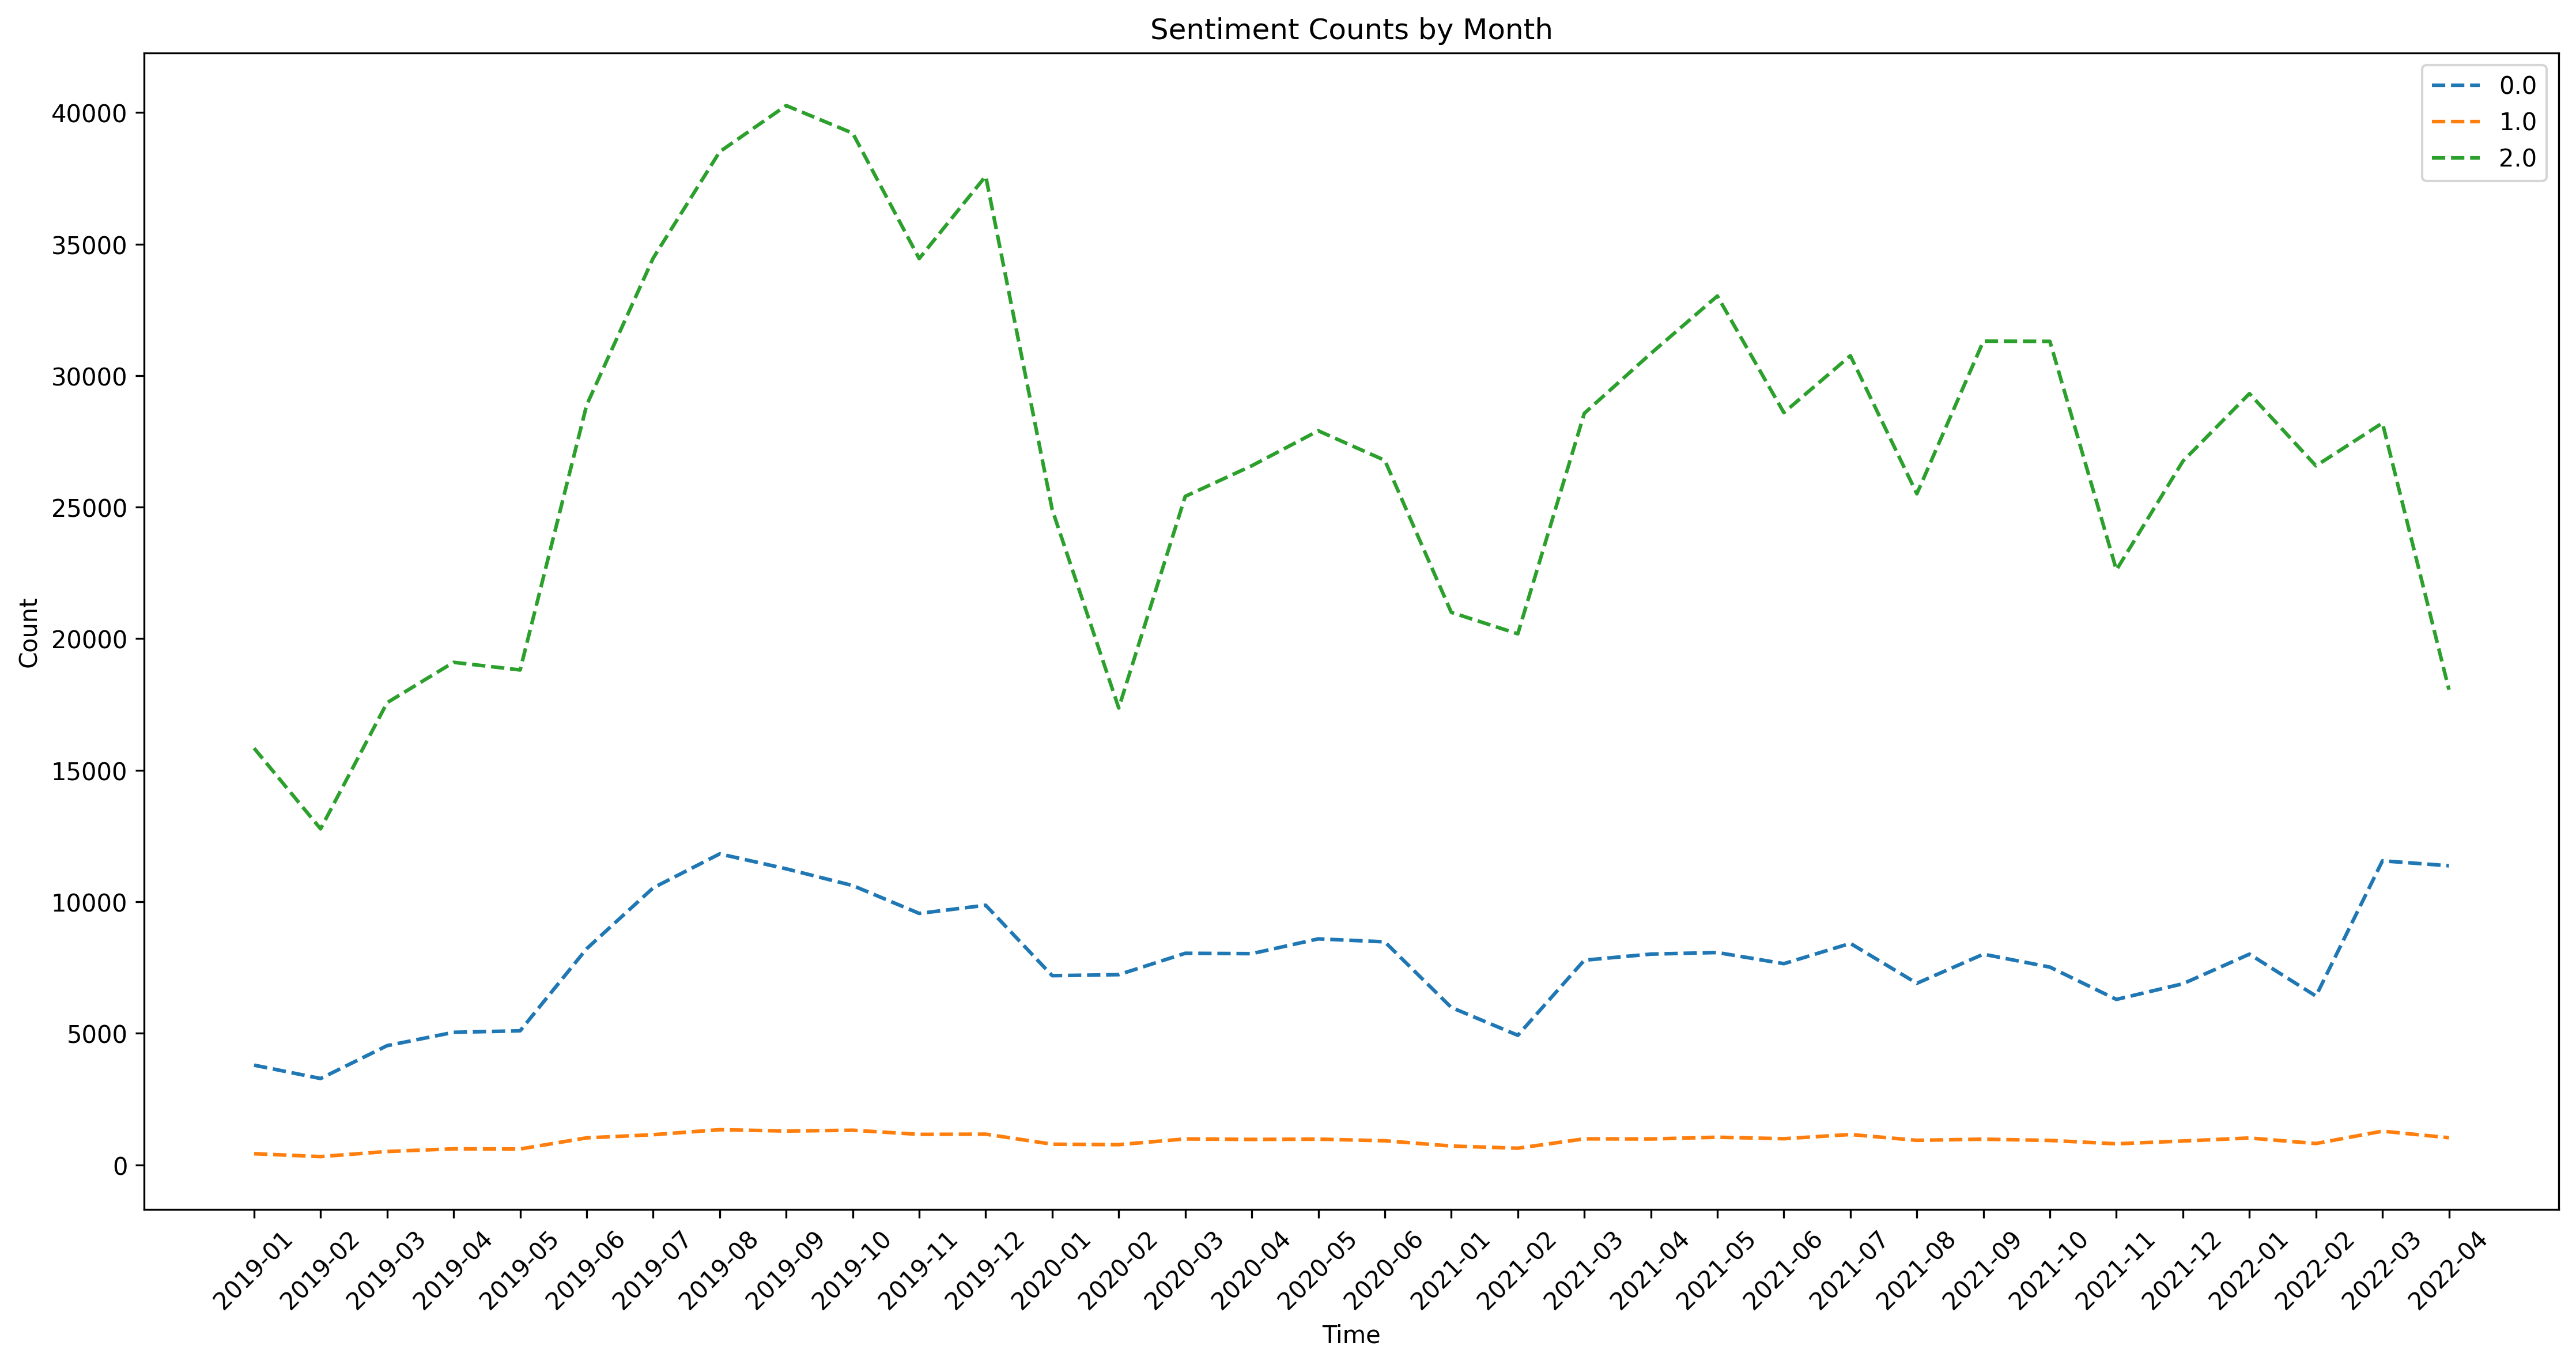

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

# 指定文件夹路径
folder_path = r'data/上海2019_2023年按月分类文件_情绪值'

# 存储所有数据
all_data = []

# 遍历文件夹中的所有csv文件
for file_name in os.listdir(folder_path):
    if file_name.endswith('.csv'):
        file_path = os.path.join(folder_path, file_name)
        data = pd.read_csv(file_path)
        # 使用正则表达式提取文件名中的日期信息
        match = re.search(r'\d{8}', file_name)
        if match:
            time_info = match.group(0)
            data['time'] = time_info
            print(time_info)

            all_data.append(data)

# 合并所有数据
df = pd.concat(all_data, ignore_index=True)

# 计算置信度
# df['baidu_confidence_score'] = df['baidu_positive'] - df['baidu_negative']
df['baidu_confidence_score'] = 2*(2*df['baidu_positive'] -1)

# 按时间排序
df['time'] = pd.to_datetime(df['time'], format='%Y%m%d')
# 只显示年和月
df['time'] = df['time'].dt.strftime('%Y-%m')
df = df.sort_values(by='time')

# 绘制箱线图
plt.figure(figsize=(15, 8), dpi=300)
sns.boxplot(x='time', y='baidu_confidence_score', data=df)
plt.title('Baidu Confidence Score Distribution by Month')
plt.xlabel('Time')
plt.ylabel('Baidu Confidence Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 统计sentiment列的每个类的个数
sentiment_counts = df.groupby(['time', 'baidu_sentiment']).size().unstack(fill_value=0)

# 绘制折线图
plt.figure(figsize=(15, 8), dpi=300)
for sentiment in sentiment_counts.columns:
    sns.lineplot(x=sentiment_counts.index, y=sentiment_counts[sentiment], label=sentiment,linestyle='--')
plt.title('Sentiment Counts by Month')
plt.xlabel('Time')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


20190101
20190201
20190301
20190401
20190501
20190601
20190701
20190801
20190901
20191001
20191101
20191201
20200101
20200201
20200301
20200401
20200501
20200601
20210101
20210201
20210301
20210401
20210501
20210601
20210701
20210801
20210901
20211001
20211101
20211201
20220101
20220201
20220301
20220401


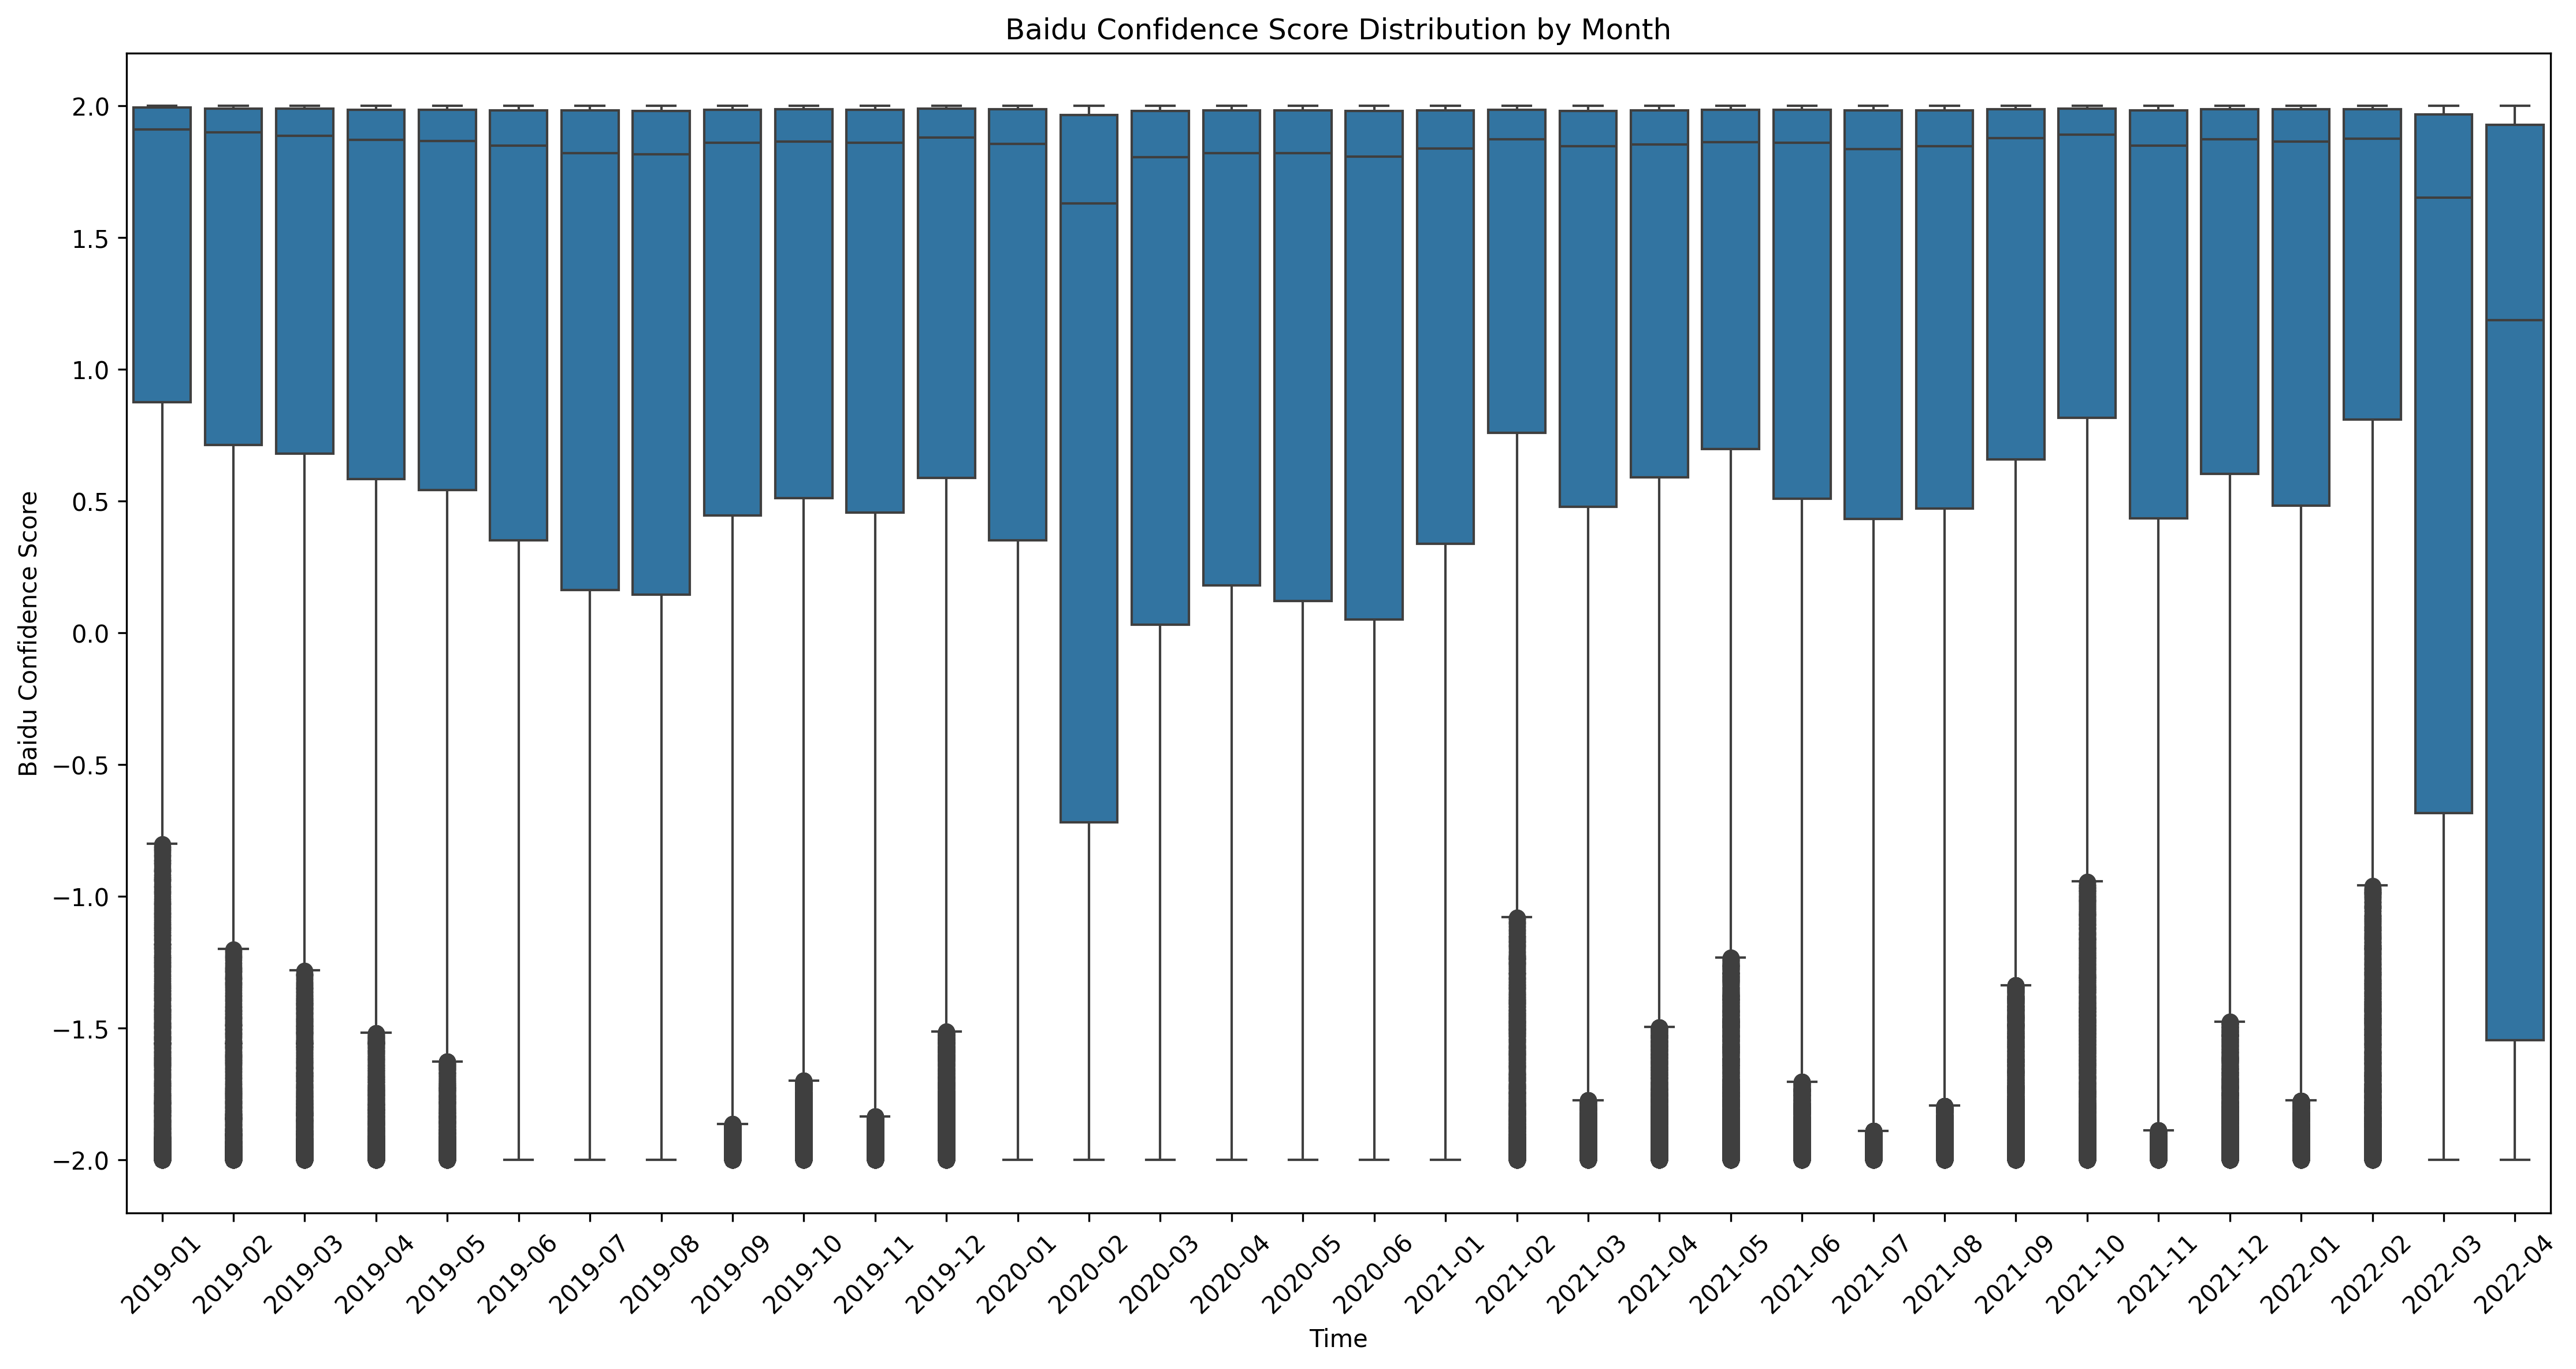

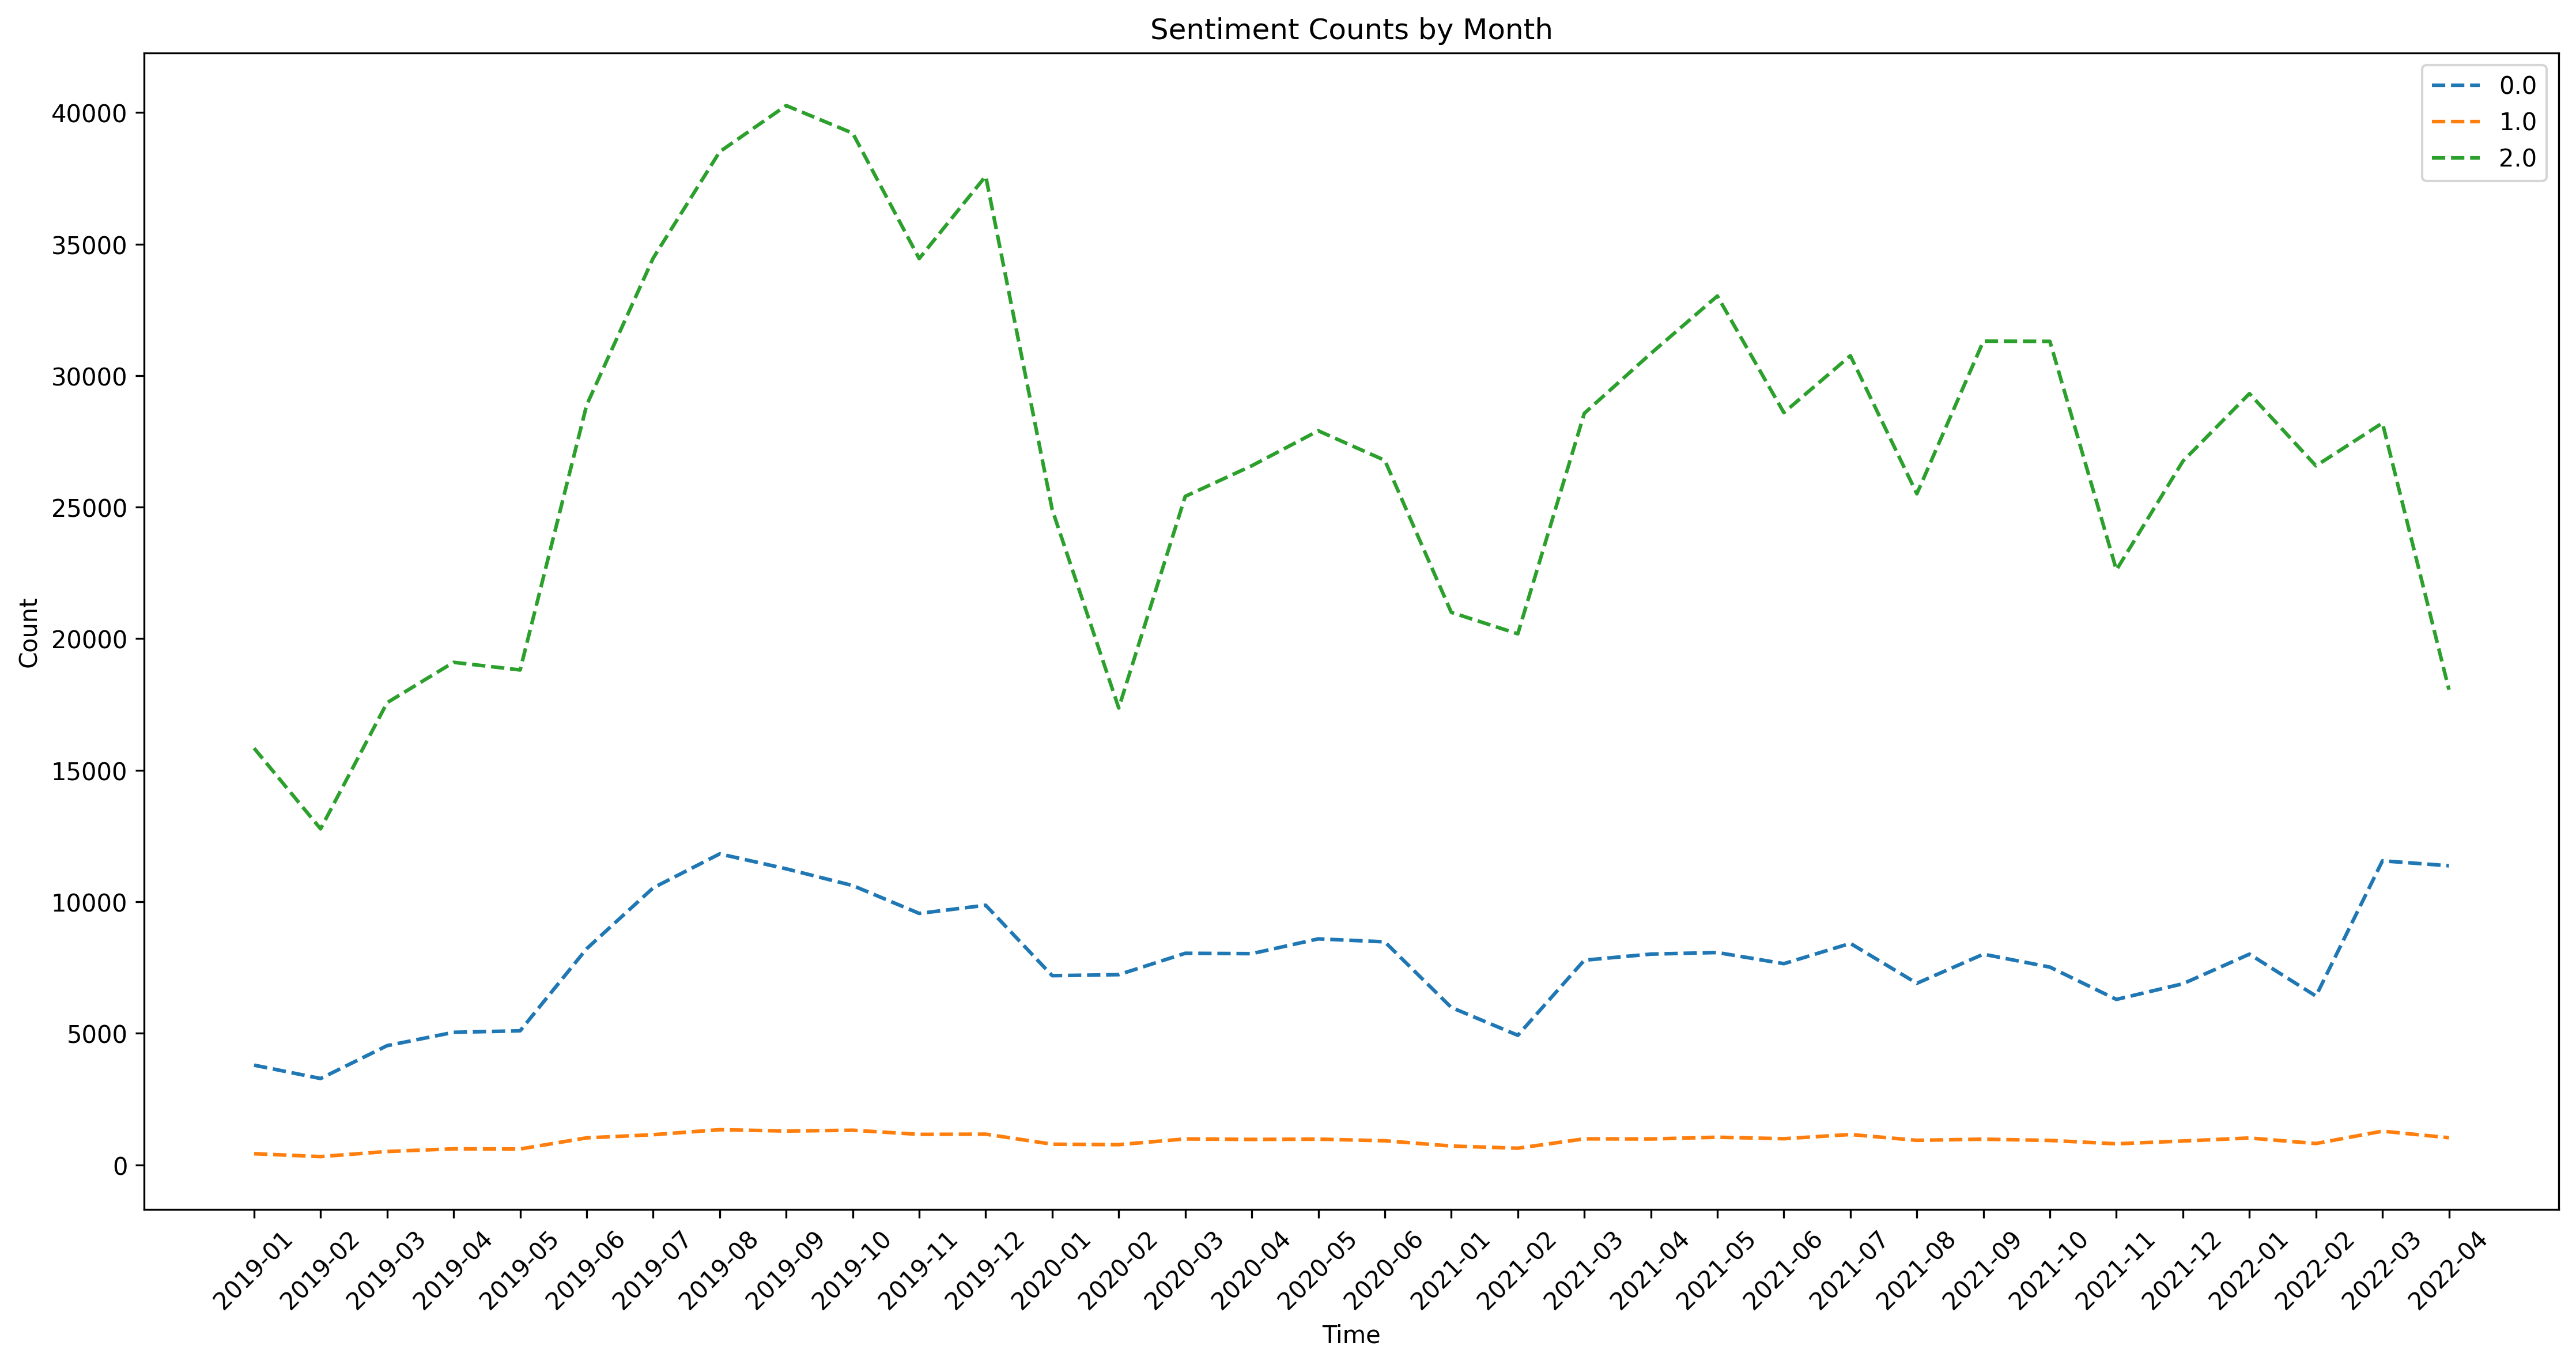

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

# 指定文件夹路径
folder_path = r'data/上海2019_2023年按月分类文件_情绪值'

# 存储所有数据
all_data = []

# 遍历文件夹中的所有csv文件
for file_name in os.listdir(folder_path):
    if file_name.endswith('.csv'):
        file_path = os.path.join(folder_path, file_name)
        data = pd.read_csv(file_path)
        # 使用正则表达式提取文件名中的日期信息
        match = re.search(r'\d{8}', file_name)
        if match:
            time_info = match.group(0)
            data['time'] = time_info
            print(time_info)

            all_data.append(data)

# 合并所有数据
df = pd.concat(all_data, ignore_index=True)

# 计算置信度
# df['baidu_confidence_score'] = df['baidu_positive'] - df['baidu_negative']
df['baidu_confidence_score'] = 2*(2*df['baidu_positive'] -1)

# 按时间排序
df['time'] = pd.to_datetime(df['time'], format='%Y%m%d')
# 只显示年和月
df['time'] = df['time'].dt.strftime('%Y-%m')
df = df.sort_values(by='time')

# 绘制箱线图
plt.figure(figsize=(15, 8), dpi=300)
sns.boxplot(x='time', y='baidu_confidence_score', data=df)
plt.title('Baidu Confidence Score Distribution by Month')
plt.xlabel('Time')
plt.ylabel('Baidu Confidence Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 统计sentiment列的每个类的个数
sentiment_counts = df.groupby(['time', 'baidu_sentiment']).size().unstack(fill_value=0)

# 绘制折线图
plt.figure(figsize=(15, 8), dpi=300)
for sentiment in sentiment_counts.columns:
    sns.lineplot(x=sentiment_counts.index, y=sentiment_counts[sentiment], label=sentiment,linestyle='--')
plt.title('Sentiment Counts by Month')
plt.xlabel('Time')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


20190101
20190201
20190301
20190401
20190501
20190601
20190701
20190801
20190901
20191001
20191101
20191201
20200101
20200201
20200301
20200401
20200501
20200601
20210101
20210201
20210301
20210401
20210501
20210601
20210701
20210801
20210901
20211001
20211101
20211201
20220101
20220201
20220301
20220401


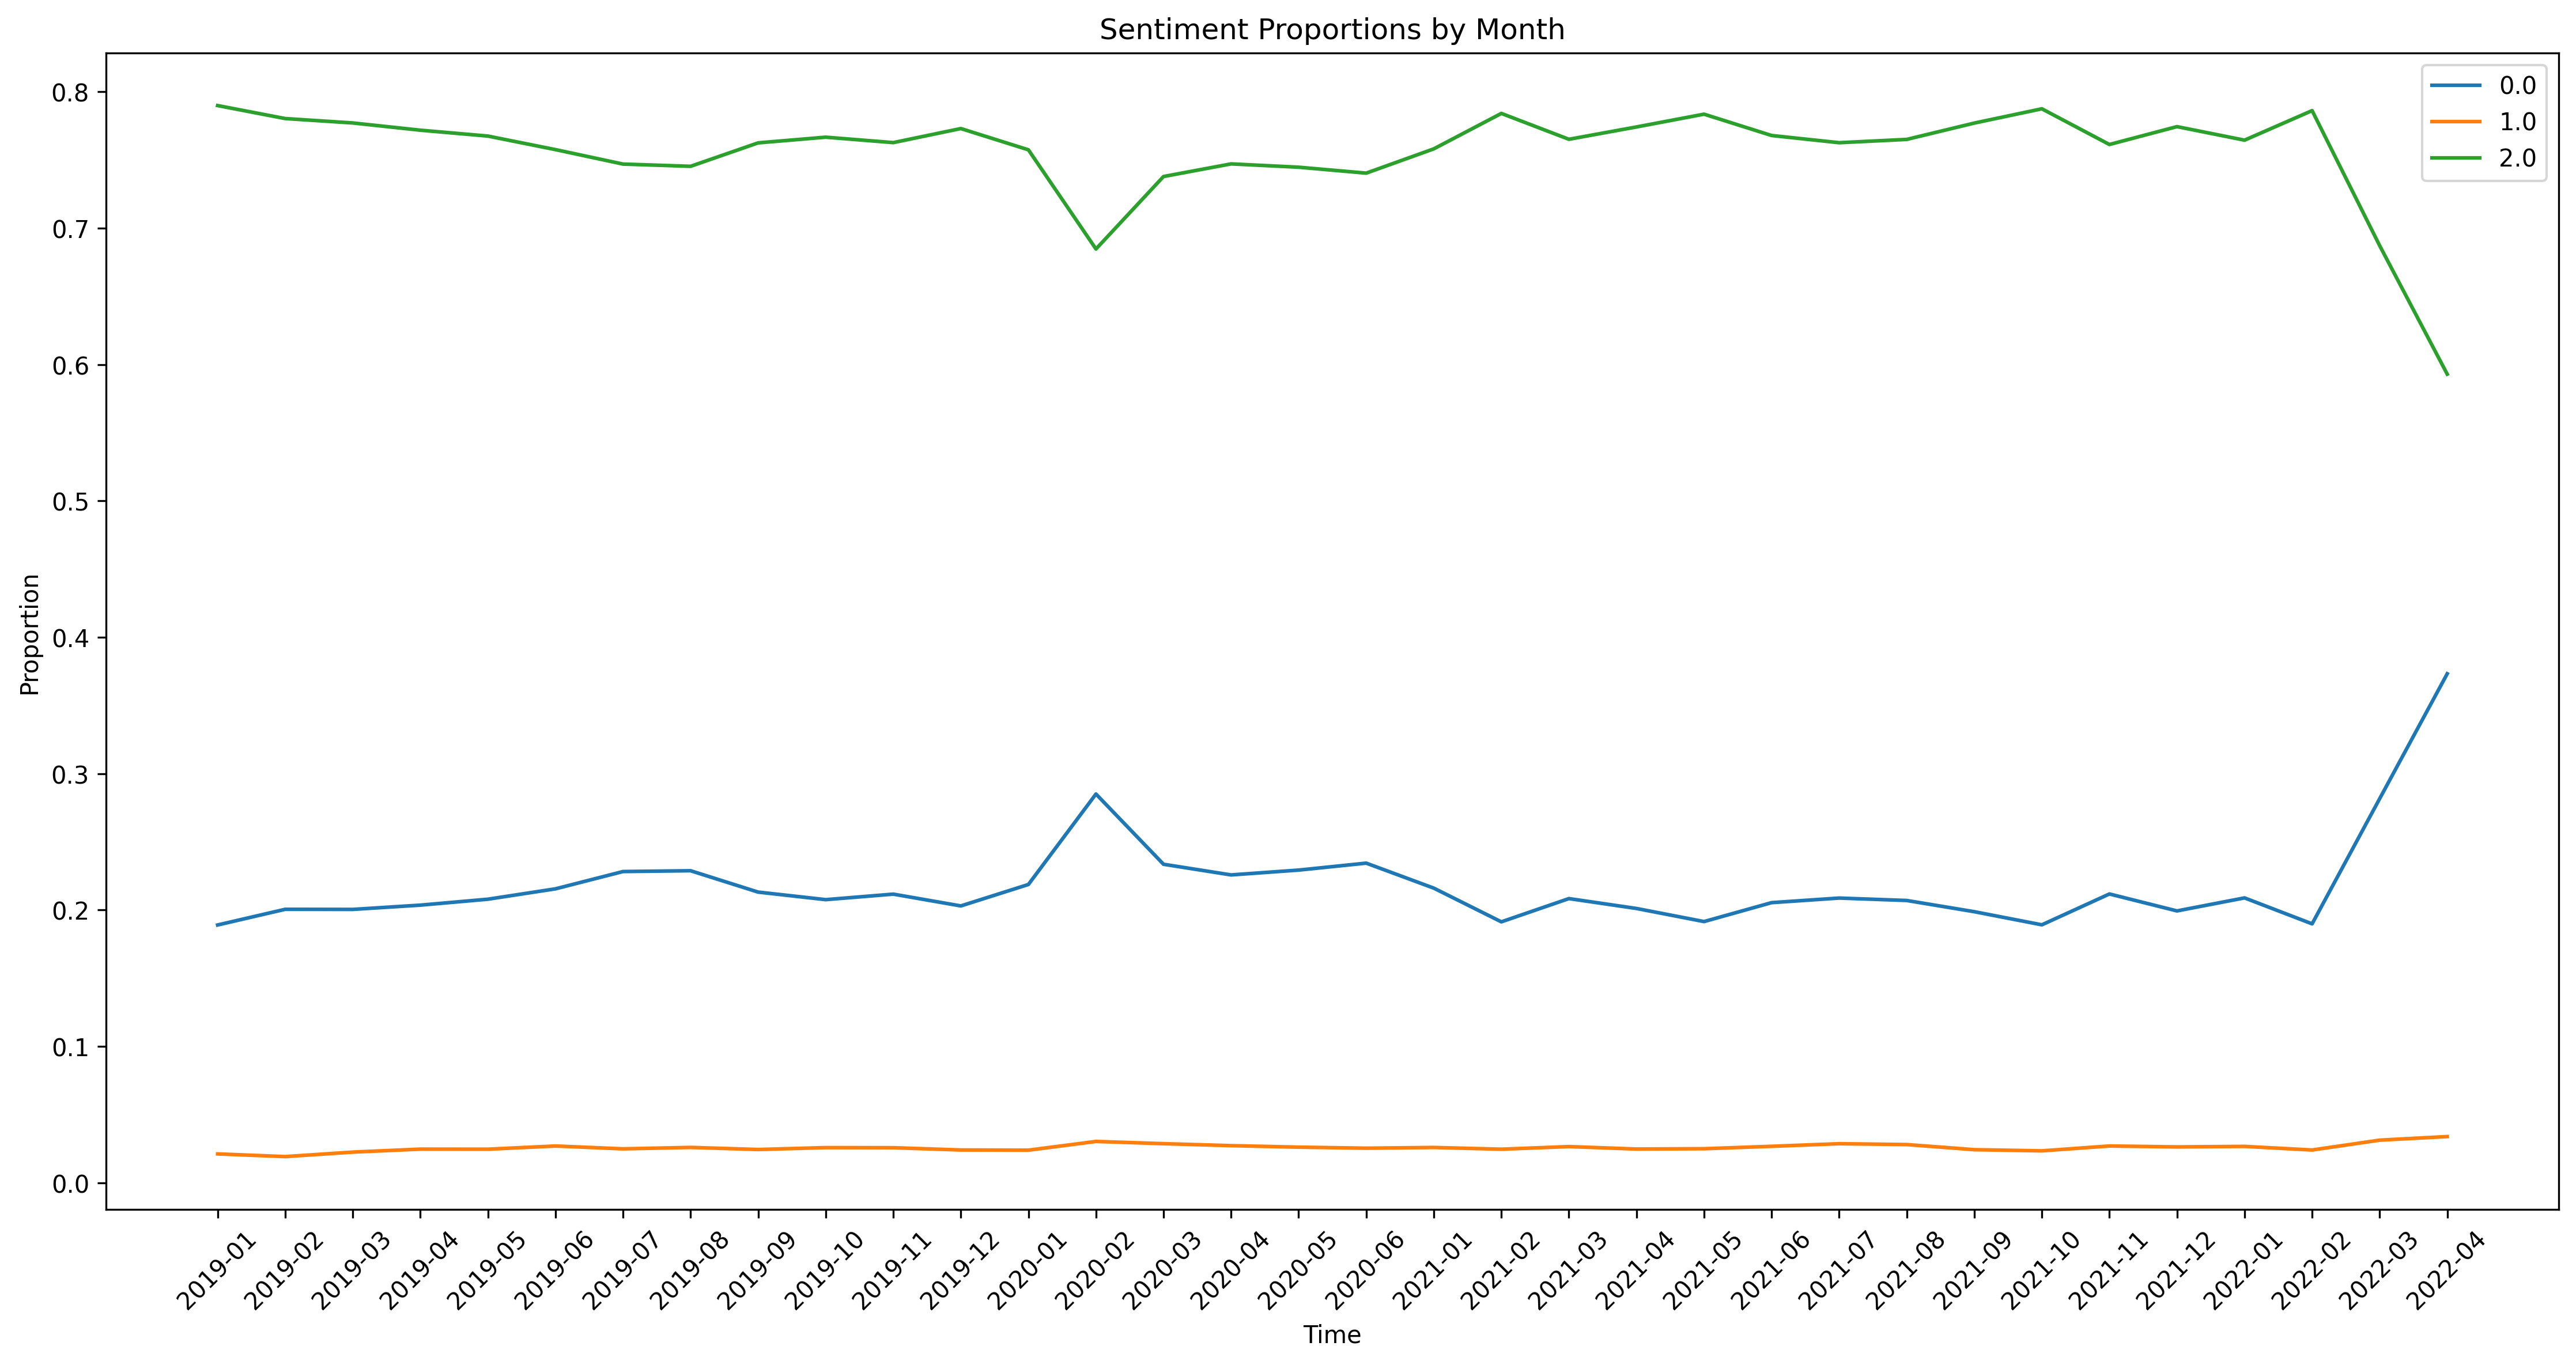

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

# 指定文件夹路径
folder_path = r'data/上海2019_2023年按月分类文件_情绪值'

# 存储所有数据
all_data = []

# 遍历文件夹中的所有csv文件
for file_name in os.listdir(folder_path):
    if file_name.endswith('.csv'):
        file_path = os.path.join(folder_path, file_name)
        data = pd.read_csv(file_path)
        # 使用正则表达式提取文件名中的日期信息
        match = re.search(r'\d{8}', file_name)
        if match:
            time_info = match.group(0)
            data['time'] = time_info
            print(time_info)

            all_data.append(data)

# 合并所有数据
df = pd.concat(all_data, ignore_index=True)

# 计算置信度
# df['baidu_confidence_score'] = df['baidu_positive'] - df['baidu_negative']
df['baidu_confidence_score'] = 2*(2*df['baidu_positive'] -1)

# 按时间排序
df['time'] = pd.to_datetime(df['time'], format='%Y%m%d')
# 只显示年和月
df['time'] = df['time'].dt.strftime('%Y-%m')
df = df.sort_values(by='time')

# 统计sentiment列的每个类的个数
sentiment_counts = df.groupby(['time', 'baidu_sentiment']).size().unstack(fill_value=0)

# 计算每个月各类sentiment占总sentiment个数的比例
sentiment_proportions = sentiment_counts.div(sentiment_counts.sum(axis=1), axis=0)

# 绘制折线图
plt.figure(figsize=(15, 8), dpi=300)
for sentiment in sentiment_proportions.columns:
    sns.lineplot(x=sentiment_proportions.index, y=sentiment_proportions[sentiment], label=sentiment)
plt.title('Sentiment Proportions by Month')
plt.xlabel('Time')
plt.ylabel('Proportion')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


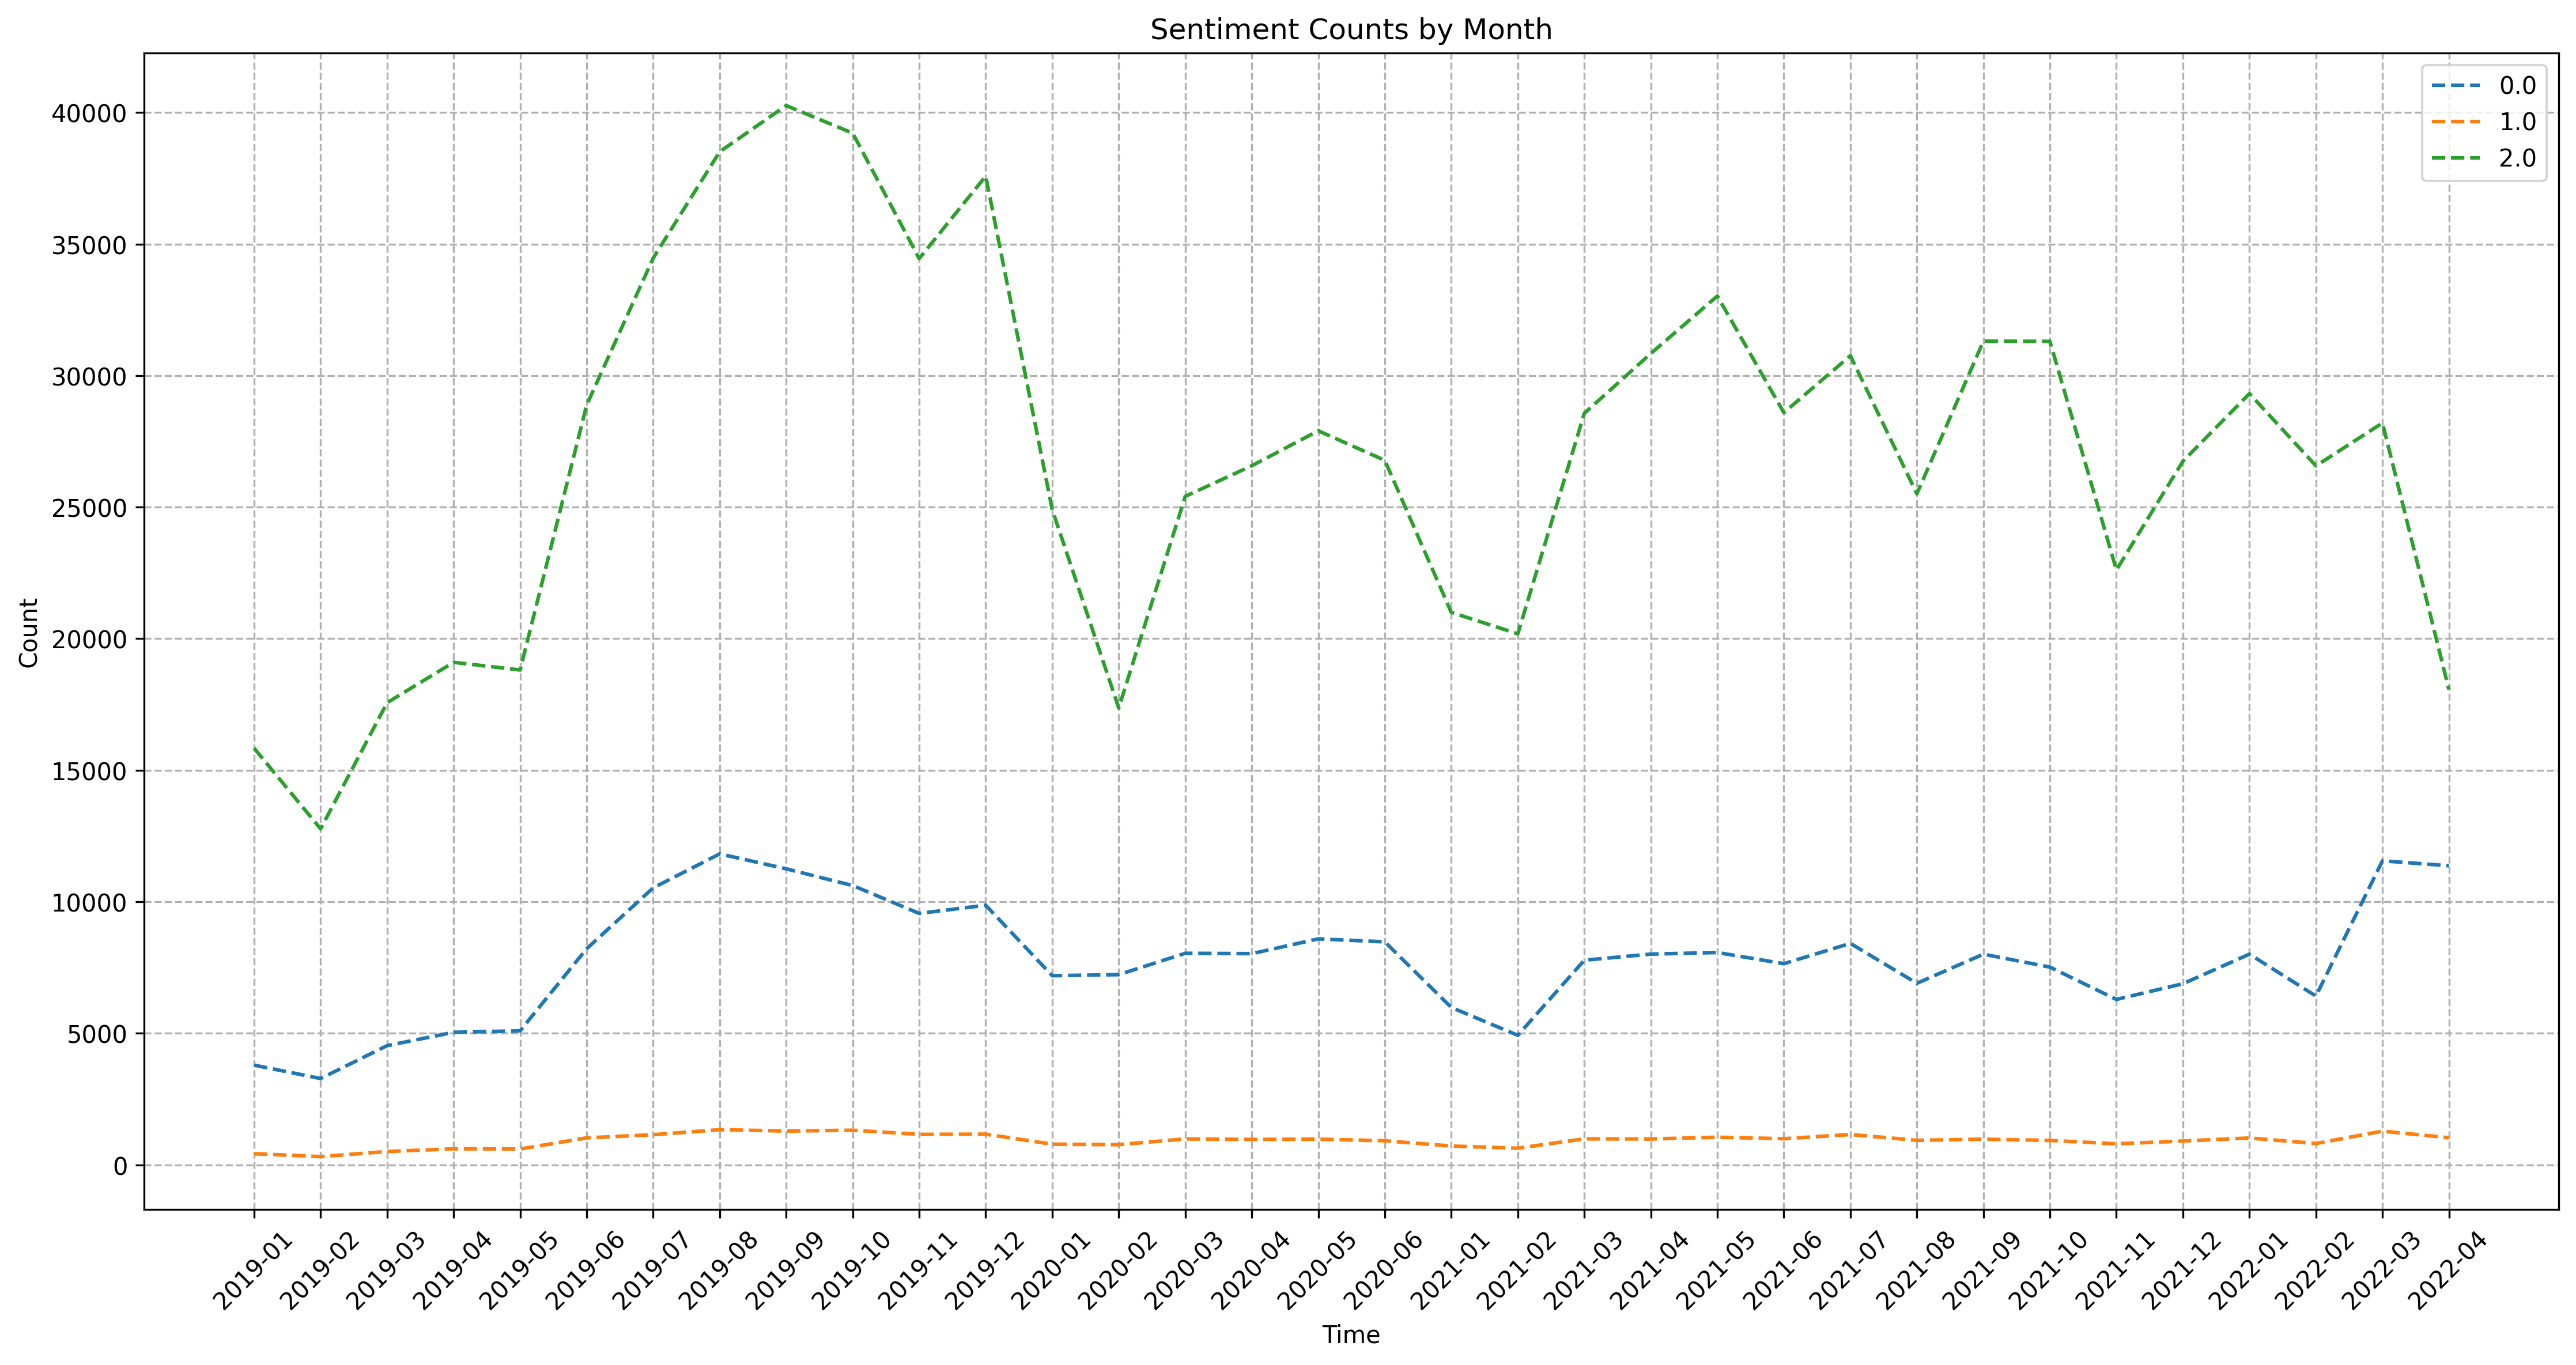

In [ ]:
# 统计sentiment列的每个类的个数
sentiment_counts = df.groupby(['time', 'baidu_sentiment']).size().unstack(fill_value=0)

# 绘制折线图
plt.figure(figsize=(15, 8), dpi=300)
for sentiment in sentiment_counts.columns:
    sns.lineplot(x=sentiment_counts.index, y=sentiment_counts[sentiment], label=sentiment,linestyle='--')
plt.title('Sentiment Counts by Month')
plt.xlabel('Time')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.grid(True,linestyle='--')
plt.show()

In [13]:
import pandas as pd
from scipy.stats import pearsonr

# 读取CSV文件
df = pd.read_csv(r'data\上海2019_2023年按月分类文件_情绪值\对比验证\20190301_20190401 26184 条_Baidu&Tencent&BERT&Ali 21747 条.csv')

# 选择需要进行相关性分析的列
columns_to_analyze = ['baidu_confidence', 'baidu_negative', 'baidu_positive', 'Tencent_positive', 'Tencent_neutral', 'Tencent_negative', 'ali_positive', 'ali_neutral', 'ali_negative']

# 计算相关性矩阵和p值矩阵
correlation_matrix = df[columns_to_analyze].corr()
p_value_matrix = pd.DataFrame(index=columns_to_analyze, columns=columns_to_analyze)

for i in columns_to_analyze:
    for j in columns_to_analyze:
        corr, p_value = pearsonr(df[i], df[j])
        p_value_matrix.loc[i, j] = p_value

# 定义显著性标注函数
def add_significance_stars(val, p_value):
    if p_value < 0.001:
        return f'{val:.2f}***'
    elif p_value < 0.01:
        return f'{val:.2f}**'
    elif p_value < 0.05:
        return f'{val:.2f}*'
    else:
        return f'{val:.2f}'

# 创建带显著性标注的相关性矩阵
annotated_corr_matrix = correlation_matrix.copy()
for i in columns_to_analyze:
    for j in columns_to_analyze:
        annotated_corr_matrix.loc[i, j] = add_significance_stars(correlation_matrix.loc[i, j], p_value_matrix.loc[i, j])

# 保存带显著性标注的相关性矩阵为CSV文件
annotated_corr_matrix.to_csv('annotated_correlation_matrix.csv', encoding='utf-8-sig')

print("带显著性标注的相关性矩阵已保存为 annotated_correlation_matrix.csv")


带显著性标注的相关性矩阵已保存为 annotated_correlation_matrix.csv


C:\Users\name\AppData\Local\Temp\ipykernel_16060\2521643834.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.00***' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  annotated_corr_matrix.loc[i, j] = add_significance_stars(correlation_matrix.loc[i, j], p_value_matrix.loc[i, j])
C:\Users\name\AppData\Local\Temp\ipykernel_16060\2521643834.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.34***' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  annotated_corr_matrix.loc[i, j] = add_significance_stars(correlation_matrix.loc[i, j], p_value_matrix.loc[i, j])
C:\Users\name\AppData\Local\Temp\ipykernel_16060\2521643834.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of 

In [7]:
import pandas as pd

data=pd.read_csv(r'data\上海2019_2023年按月分类文件_情绪值\百度+腾讯的对比验证\20190301_20190401 26184 条_Baidu&Tencent&BERT&Ali 21747 条.csv')
# data

In [2]:
data=data[['baidu_confidence','baidu_negative','baidu_positive','Tencent_positive','Tencent_neutral','Tencent_negative','BERT_ad_prob','ali_positive','ali_negative','ali_neutral']]
data['baidu_confidence_score'] = data['baidu_positive'] - data['baidu_negative']
data['Tencent_confidence_score'] = data['Tencent_positive'] - data['Tencent_negative']
data['BERT_confidence_score'] = 2*data['BERT_ad_prob']-1
data


baidu_confidence  baidu_negative  baidu_positive  Tencent_positive  \
0              0.974418        0.011512        0.988488          0.654513   
1              0.883366        0.052485        0.947515          0.008661   
2              0.753050        0.888873        0.111128          0.031652   
3              0.967932        0.985569        0.014431          0.001443   
4              0.903323        0.043505        0.956495          0.012902   
...                 ...             ...             ...               ...   
21742          0.975071        0.011218        0.988782          0.001364   
21743          0.968225        0.014299        0.985701          0.078459   
21744          0.812437        0.084403        0.915597          0.014182   
21745          0.996551        0.001552        0.998448          0.022772   
21746          0.755430        0.889944        0.110056          0.273316   

       Tencent_neutral  Tencent_negative  BERT_ad_prob  \
0             0.330944          0.014543      0.998641   
1             0.971560          0.019779      0.534058   
2             0.955590          0.012758      0.456147   
3             0.948951          0.049606      0.681232   
4             0.773490          0.213608      0.990154   
...                ...               ...           ...   
21742         0.915914          0.082722      0.354155   
21743         0.456041          0.465499      0.998867   
21744         0.913831          0.071988      0.697365   
21745         0.973864          0.003364      0.992992   
21746         0.707915          0.018770      0.549738   

       baidu_confidence_score  Tencent_confidence_score  BERT_confidence_score  
0                    0.976976                  0.639970               0.997282  
1                    0.895030                 -0.011118               0.068116  
2                   -0.777745                  0.018895              -0.087707  
3                   -0.971138                 -0.048163               0.362464  
4                    0.912990                 -0.200705               0.980308  
...                       ...                       ...                    ...  
21742                0.977564                 -0.081357              -0.291689  
21743                0.971402                 -0.387040               0.997733  
21744                0.831194                 -0.057806               0.394731  
21745                0.996896                  0.019408               0.985984  
21746               -0.779888                  0.254546               0.099476  

[21747 rows x 10 columns]

In [8]:
data=data[['baidu_confidence','baidu_negative','baidu_positive','Tencent_positive','Tencent_neutral','Tencent_negative','BERT_ad_prob','ali_positive','ali_negative','ali_neutral']]
data['baidu_confidence_score'] = data['baidu_positive']
data['Tencent_confidence_score'] = data['Tencent_positive']
data['ali_confidence_score']=data['ali_positive']
data['BERT_confidence_score'] = data['BERT_ad_prob']
data


baidu_confidence  baidu_negative  baidu_positive  Tencent_positive  \
0              0.974418        0.011512        0.988488          0.654513   
1              0.883366        0.052485        0.947515          0.008661   
2              0.753050        0.888873        0.111128          0.031652   
3              0.967932        0.985569        0.014431          0.001443   
4              0.903323        0.043505        0.956495          0.012902   
...                 ...             ...             ...               ...   
21742          0.975071        0.011218        0.988782          0.001364   
21743          0.968225        0.014299        0.985701          0.078459   
21744          0.812437        0.084403        0.915597          0.014182   
21745          0.996551        0.001552        0.998448          0.022772   
21746          0.755430        0.889944        0.110056          0.273316   

       Tencent_neutral  Tencent_negative  BERT_ad_prob  ali_positive  \
0             0.330944          0.014543      0.998641        0.9982   
1             0.971560          0.019779      0.534058        0.4453   
2             0.955590          0.012758      0.456147        0.3252   
3             0.948951          0.049606      0.681232        0.9913   
4             0.773490          0.213608      0.990154        0.8974   
...                ...               ...           ...           ...   
21742         0.915914          0.082722      0.354155        0.9982   
21743         0.456041          0.465499      0.998867        0.9284   
21744         0.913831          0.071988      0.697365        0.9888   
21745         0.973864          0.003364      0.992992        0.9970   
21746         0.707915          0.018770      0.549738        0.3491   

       ali_negative  ali_neutral  baidu_confidence_score  \
0            0.0017       0.0000                0.988488   
1            0.5382       0.0164                0.947515   
2            0.6529       0.0217                0.111128   
3            0.0084       0.0003                0.014431   
4            0.0849       0.0176                0.956495   
...             ...          ...                     ...   
21742        0.0017       0.0001                0.988782   
21743        0.0580       0.0135                0.985701   
21744        0.0104       0.0008                0.915597   
21745        0.0028       0.0001                0.998448   
21746        0.6381       0.0127                0.110056   

       Tencent_confidence_score  ali_confidence_score  BERT_confidence_score  
0                      0.654513                0.9982               0.998641  
1                      0.008661                0.4453               0.534058  
2                      0.031652                0.3252               0.456147  
3                      0.001443                0.9913               0.681232  
4                      0.012902                0.8974               0.990154  
...                         ...                   ...                    ...  
21742                  0.001364                0.9982               0.354155  
21743                  0.078459                0.9284               0.998867  
21744                  0.014182                0.9888               0.697365  
21745                  0.022772                0.9970               0.992992  
21746                  0.273316                0.3491               0.549738  

[21747 rows x 14 columns]

In [9]:
data=data[['baidu_confidence_score','Tencent_confidence_score','ali_confidence_score','BERT_confidence_score']]
data

baidu_confidence_score  Tencent_confidence_score  ali_confidence_score  \
0                    0.988488                  0.654513                0.9982   
1                    0.947515                  0.008661                0.4453   
2                    0.111128                  0.031652                0.3252   
3                    0.014431                  0.001443                0.9913   
4                    0.956495                  0.012902                0.8974   
...                       ...                       ...                   ...   
21742                0.988782                  0.001364                0.9982   
21743                0.985701                  0.078459                0.9284   
21744                0.915597                  0.014182                0.9888   
21745                0.998448                  0.022772                0.9970   
21746                0.110056                  0.273316                0.3491   

       BERT_confidence_score  
0                   0.998641  
1                   0.534058  
2                   0.456147  
3                   0.681232  
4                   0.990154  
...                      ...  
21742               0.354155  
21743               0.998867  
21744               0.697365  
21745               0.992992  
21746               0.549738  

[21747 rows x 4 columns]

In [16]:
import numpy as np
data=np.log10(data+0.1)
data

d:\ProgramData\ML\lib\site-packages\pandas\core\internals\blocks.py:393: RuntimeWarning: invalid value encountered in log10
  result = func(self.values, **kwargs)


baidu_confidence_score  Tencent_confidence_score  BERT_confidence_score
0                    0.032206                 -0.130786               0.040318
1                   -0.002164                 -1.051185              -0.774390
2                         NaN                 -0.924838              -1.910331
3                         NaN                 -1.285361              -0.334922
4                    0.005605                       NaN               0.033548
...                       ...                       ...                    ...
21742                0.032443                 -1.729493                    NaN
21743                0.029952                       NaN               0.040497
21744               -0.030960                 -1.374749              -0.305631
21745                0.040165                 -0.922966               0.035823
21746                     NaN                 -0.450328              -0.700110

[21747 rows x 3 columns]

In [10]:
data.corr()

baidu_confidence_score  Tencent_confidence_score  \
baidu_confidence_score                  1.000000                  0.293760   
Tencent_confidence_score                0.293760                  1.000000   
ali_confidence_score                    0.339234                  0.226528   
BERT_confidence_score                   0.408879                  0.346085   

                          ali_confidence_score  BERT_confidence_score  
baidu_confidence_score                0.339234               0.408879  
Tencent_confidence_score              0.226528               0.346085  
ali_confidence_score                  1.000000               0.219095  
BERT_confidence_score                 0.219095               1.000000

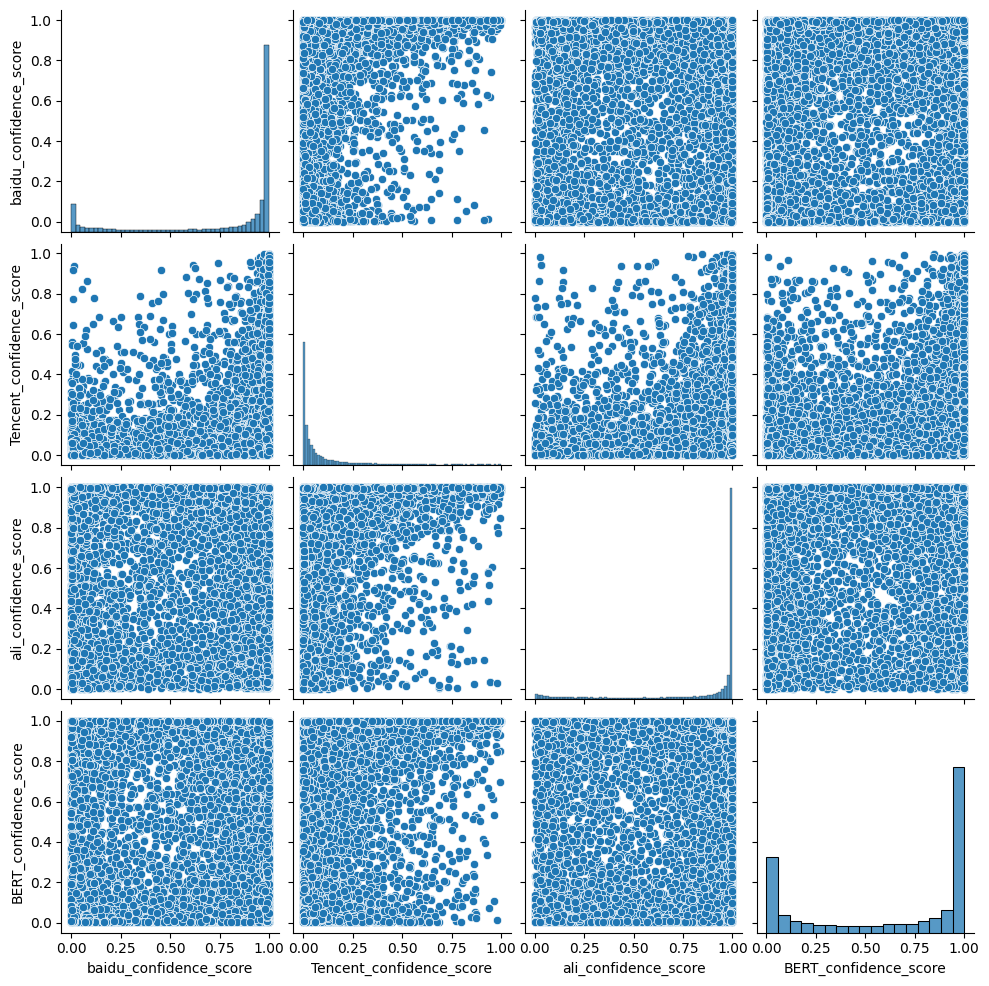

In [11]:
import seaborn as sns

sns.pairplot(data)

按时间序列（日、月）对积极的情感的中位数/平均数 进行曲线的绘制

           publish_time  baidu_confidence  baidu_negative  baidu_positive  \
0      2022-09-01 00:00          0.998606        0.000627        0.999373   
1      2022-09-01 00:00          0.967423        0.014660        0.985340   
2      2022-09-01 00:01          0.999436        0.000254        0.999746   
3      2022-09-01 00:02          0.934098        0.029656        0.970344   
4      2022-09-01 00:02          0.044687        0.570109        0.429891   
...                 ...               ...             ...             ...   
53941  2022-09-30 23:59          0.988325        0.005254        0.994746   
53942  2022-09-30 23:59          0.996947        0.001374        0.998626   
53943  2022-09-30 23:59          0.937021        0.028341        0.971659   
53944  2022-09-30 23:59          0.997151        0.001282        0.998718   
53945  2022-09-30 23:59          0.950472        0.022288        0.977712   

       baidu_sentiment  
0                  2.0  
1                  2.0  


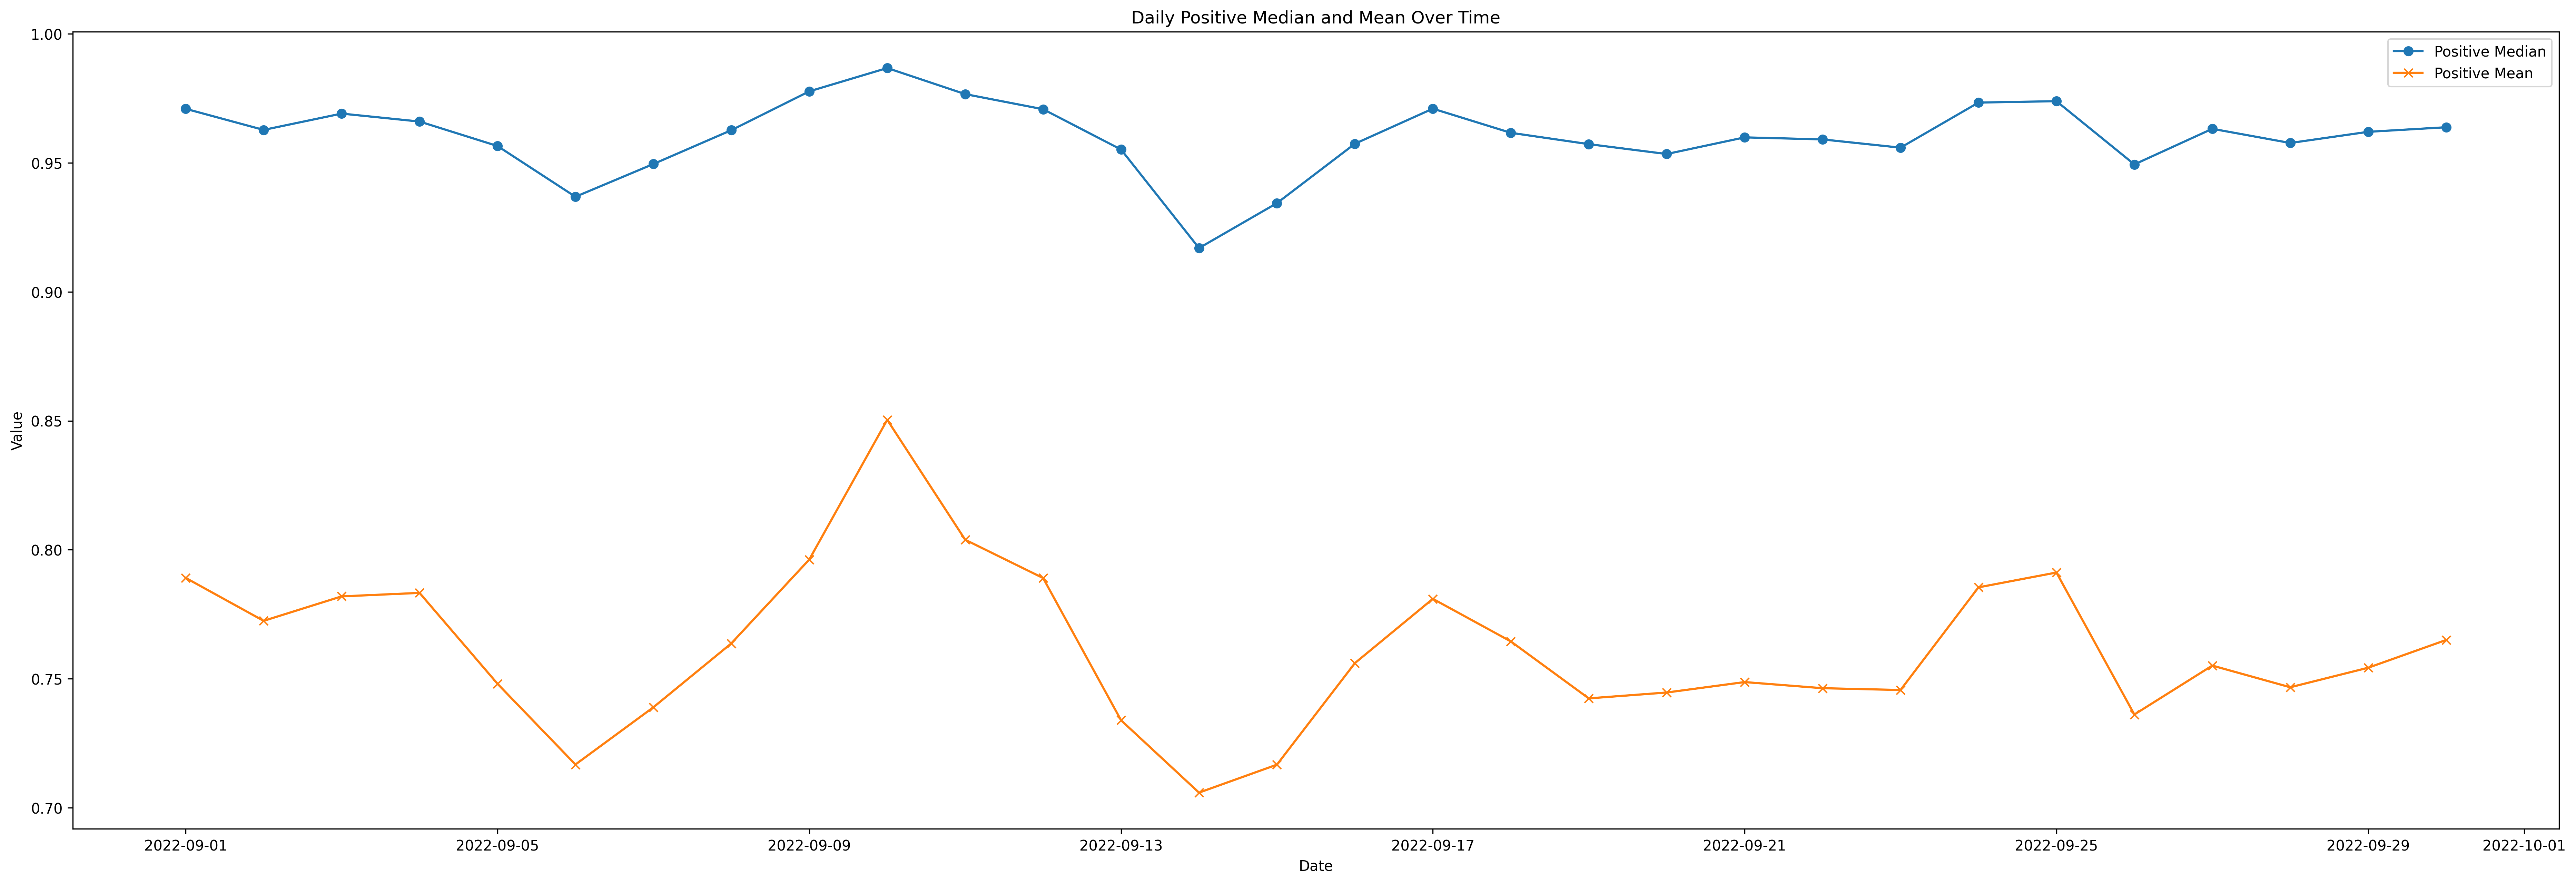

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd

daily=pd.read_csv(r'data\上海2019_2023年按月分类文件_情绪值\20220901_20221001 65098 条_Baidu.csv')
daily=daily[['publish_time','baidu_confidence','baidu_negative','baidu_positive','baidu_sentiment']]
print(daily)

# 将publish_time转换为日期格式
daily["publish_time"] = pd.to_datetime(daily["publish_time"])

# 按日分组，计算每日positive值的中位数和平均数
daily_stats = (
    daily.groupby(daily["publish_time"].dt.date)
    .agg({"baidu_positive": ["median", "mean"]})
    .reset_index()
)

# 重命名列以便于后续处理
daily_stats.columns = ["date", "positive_median", "positive_mean"]

# 将日期列转换为datetime格式
daily_stats["date"] = pd.to_datetime(daily_stats["date"])

# 绘制图表
plt.figure(figsize=(31, 10),dpi=300)

# 绘制中位数曲线
plt.plot(
    daily_stats["date"],
    daily_stats["positive_median"],
    label="Positive Median",
    marker="o",
)

# 绘制平均数曲线
plt.plot(
    daily_stats["date"], daily_stats["positive_mean"], label="Positive Mean", marker="x"
)

# 设置图表标题和标签
plt.title("Daily Positive Median and Mean Over Time")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()

# 显示图表
plt.show()

C:\Users\name\AppData\Local\Temp\ipykernel_17968\209669283.py:18: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data['publish_time']=pd.to_datetime(data['publish_time'], infer_datetime_format=True)
C:\Users\name\AppData\Local\Temp\ipykernel_17968\209669283.py:18: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data['publish_time']=pd.to_datetime(data['publish_time'], infer_datetime_format=True)
C:\Users\name\AppData\Local\Temp\ipykernel_17968\209669283.py:18: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future vers

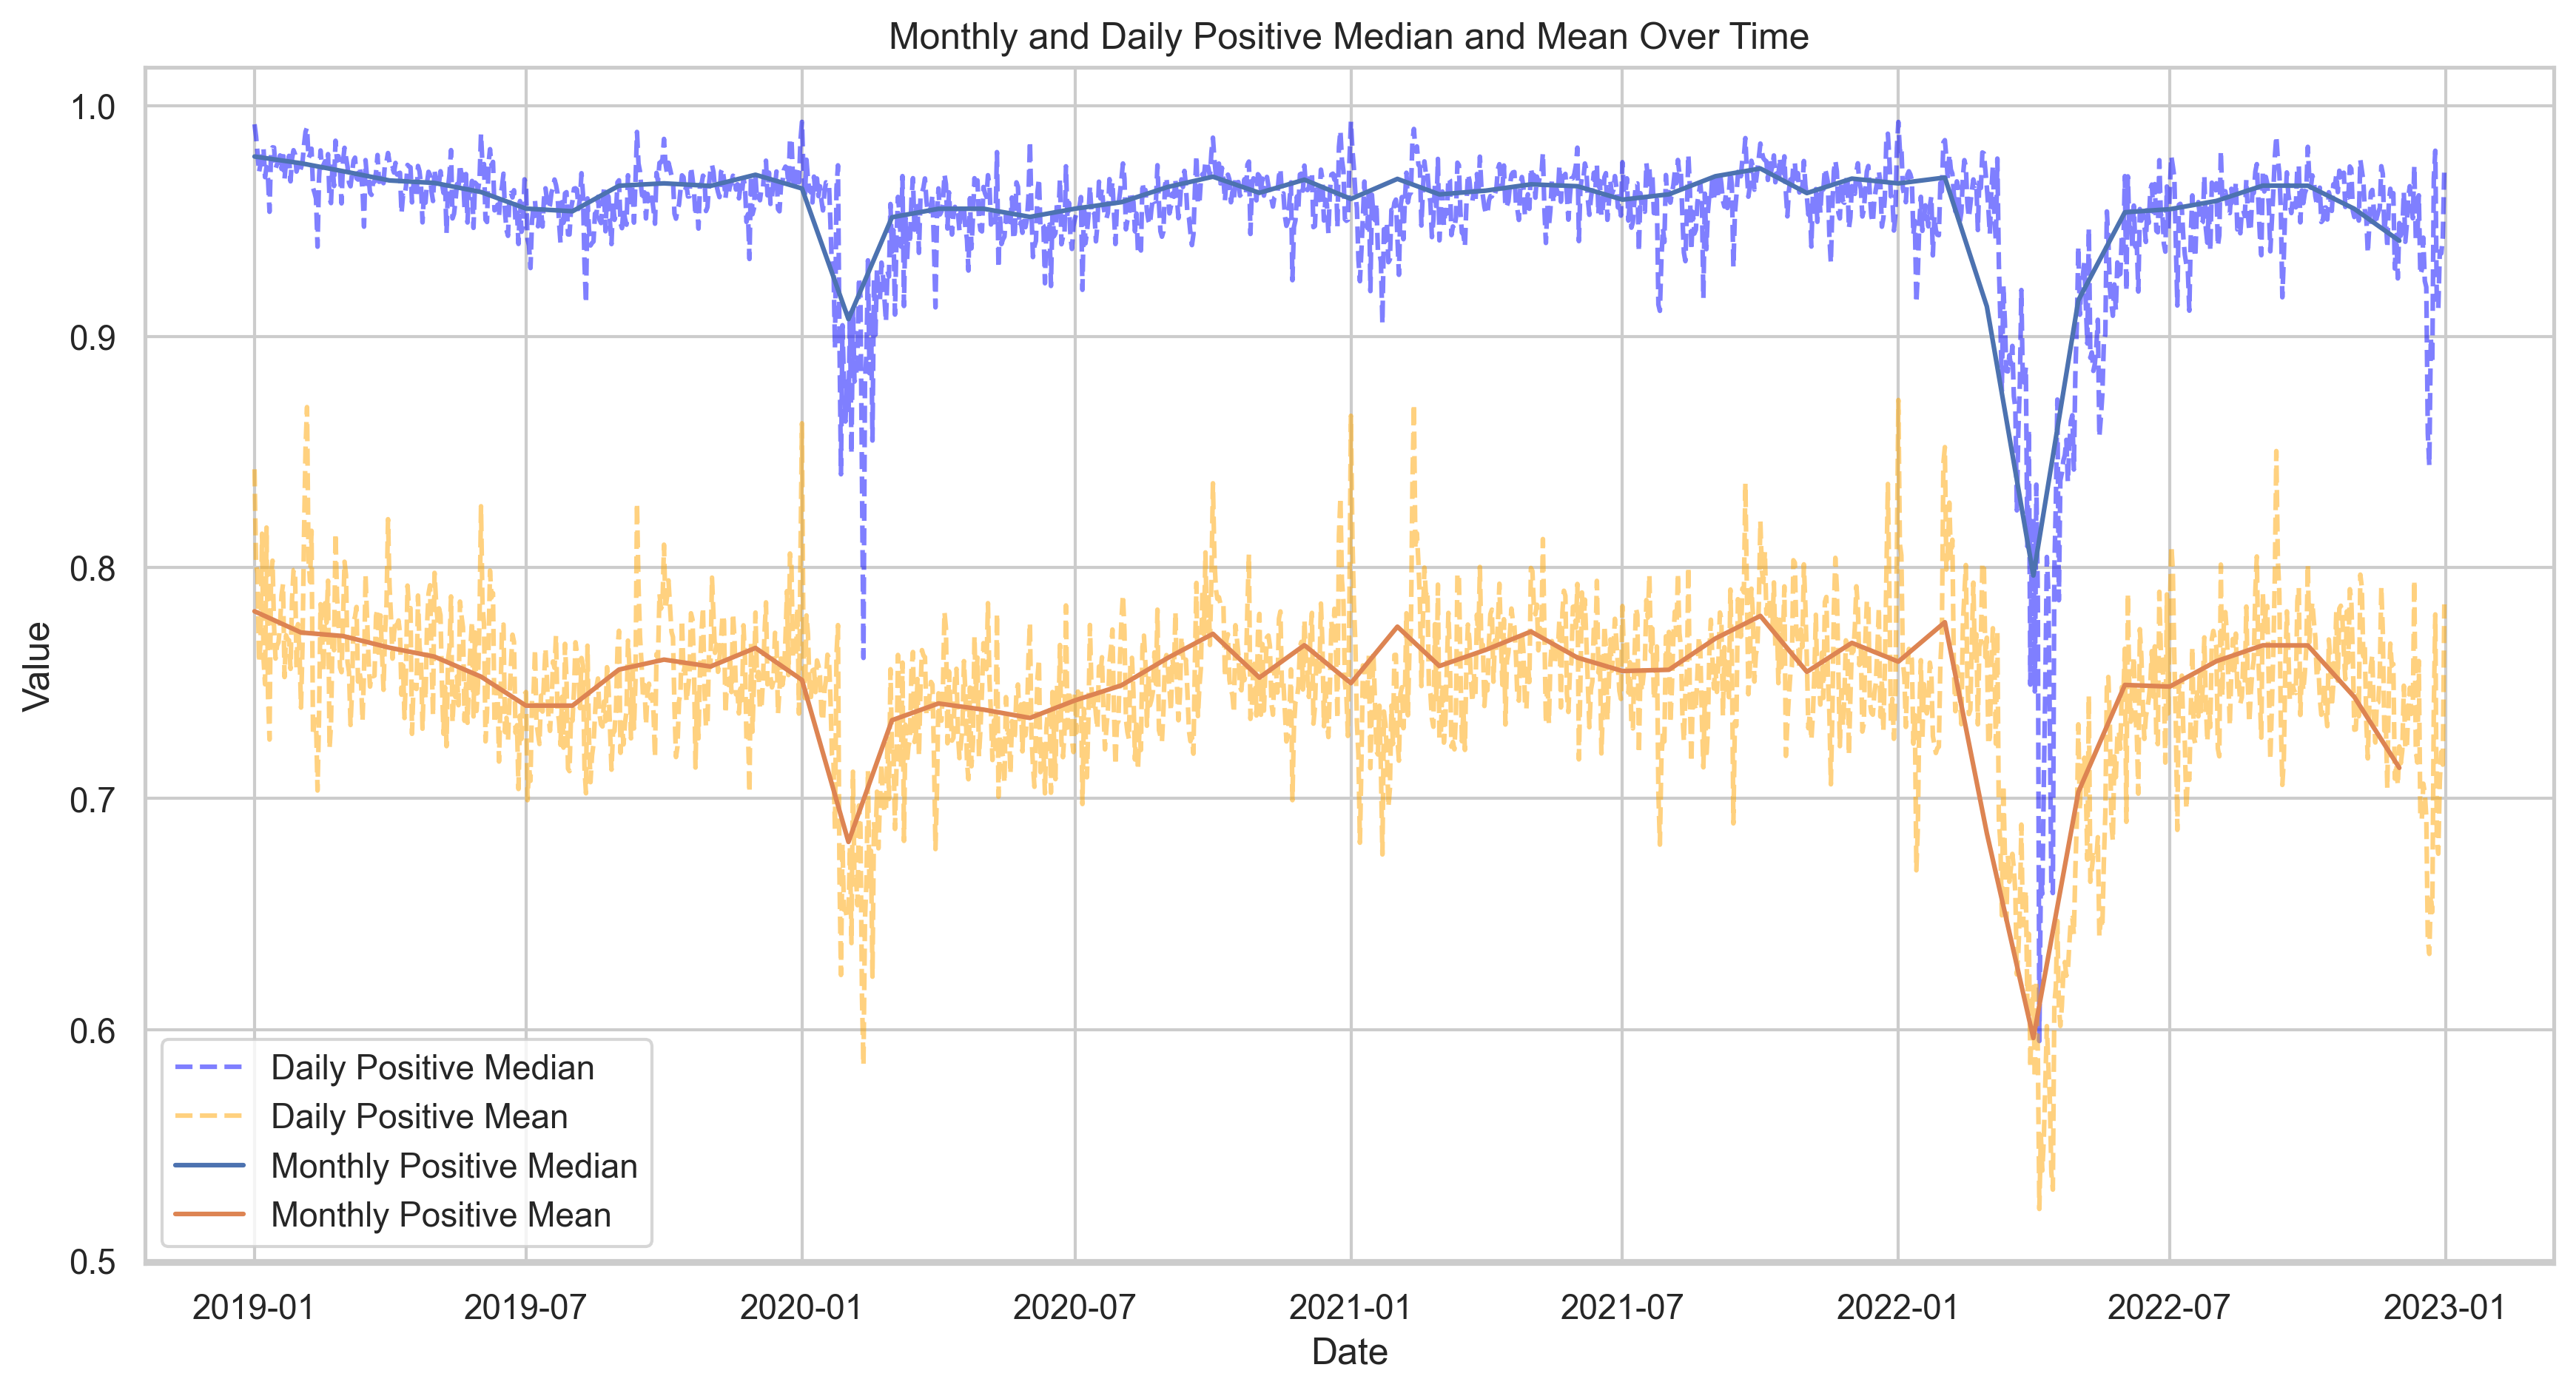

In [27]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob

# 指定文件夹路径
folder_path = r'data/上海2019_2023年按月分类文件_情绪值'

# 存储所有数据
all_data = []

# 使用glob模块遍历文件夹中的所有csv文件
for file_path in glob.glob(os.path.join(folder_path, '*.csv')):
    try:
        data = pd.read_csv(file_path)
        data=data[['publish_time','baidu_confidence','baidu_negative','baidu_positive','baidu_sentiment']]
        data['publish_time']=pd.to_datetime(data['publish_time'], infer_datetime_format=True)
        all_data.append(data)
    except Exception as e:
        print(f"Error reading file {file_path}: {e}")

# 合并所有数据
df = pd.concat(all_data, ignore_index=True)

# 按日分组，计算每日positive值的中位数和平均数
daily_stats = df.groupby(df['publish_time'].dt.date).agg({
    'baidu_positive': ['median', 'mean']
}).reset_index()

# 重命名列以便于后续处理
daily_stats.columns = ['date', 'positive_median_daily', 'positive_mean_daily']

# 将日期列转换为datetime格式
daily_stats['date'] = pd.to_datetime(daily_stats['date'])

# 按月分组，计算每月positive值的中位数和平均数
monthly_stats = df.groupby(df['publish_time'].dt.to_period('M').dt.to_timestamp()).agg({
    'baidu_positive': ['median', 'mean']
}).reset_index()

# 重命名列以便于后续处理
monthly_stats.columns = ['date', 'positive_median_monthly', 'positive_mean_monthly']

# 将日期列转换为datetime格式
monthly_stats['date'] = pd.to_datetime(monthly_stats['date'])

# 设置seaborn风格
sns.set(style="whitegrid")

# 绘制图表
plt.figure(figsize=(14, 7), dpi=300)

# 绘制按日计算的中位数曲线（虚线）
sns.lineplot(x='date', y='positive_median_daily', data=daily_stats, linestyle='--', color='blue', label='Daily Positive Median',alpha=0.5)

# 绘制按日计算的平均数曲线（虚线）
sns.lineplot(x='date', y='positive_mean_daily', data=daily_stats, linestyle='--', color='orange', label='Daily Positive Mean',alpha=0.5)

# 绘制按月计算的中位数曲线（实线）
# sns.lineplot(x='date', y='positive_median_monthly', data=monthly_stats, label='Monthly Positive Median', marker='o')
sns.lineplot(x='date', y='positive_median_monthly', data=monthly_stats, label='Monthly Positive Median')

# 绘制按月计算的平均数曲线（实线）
# sns.lineplot(x='date', y='positive_mean_monthly', data=monthly_stats, label='Monthly Positive Mean', marker='x')
sns.lineplot(x='date', y='positive_mean_monthly', data=monthly_stats, label='Monthly Positive Mean')



# 设置图表标题和标签
plt.title('Monthly and Daily Positive Median and Mean Over Time')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()

# 显示图表
plt.show()

daily_stats.to_csv('out/figure/Positive_daily_stats.csv', index=False,encoding='utf-8-sig')
monthly_stats.to_csv('out/figure/Positive_monthly_stats.csv', index=False,encoding='utf-8-sig')


C:\Users\name\AppData\Local\Temp\ipykernel_17968\2265680182.py:18: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data['publish_time']=pd.to_datetime(data['publish_time'], infer_datetime_format=True)
C:\Users\name\AppData\Local\Temp\ipykernel_17968\2265680182.py:18: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data['publish_time']=pd.to_datetime(data['publish_time'], infer_datetime_format=True)
C:\Users\name\AppData\Local\Temp\ipykernel_17968\2265680182.py:18: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future v

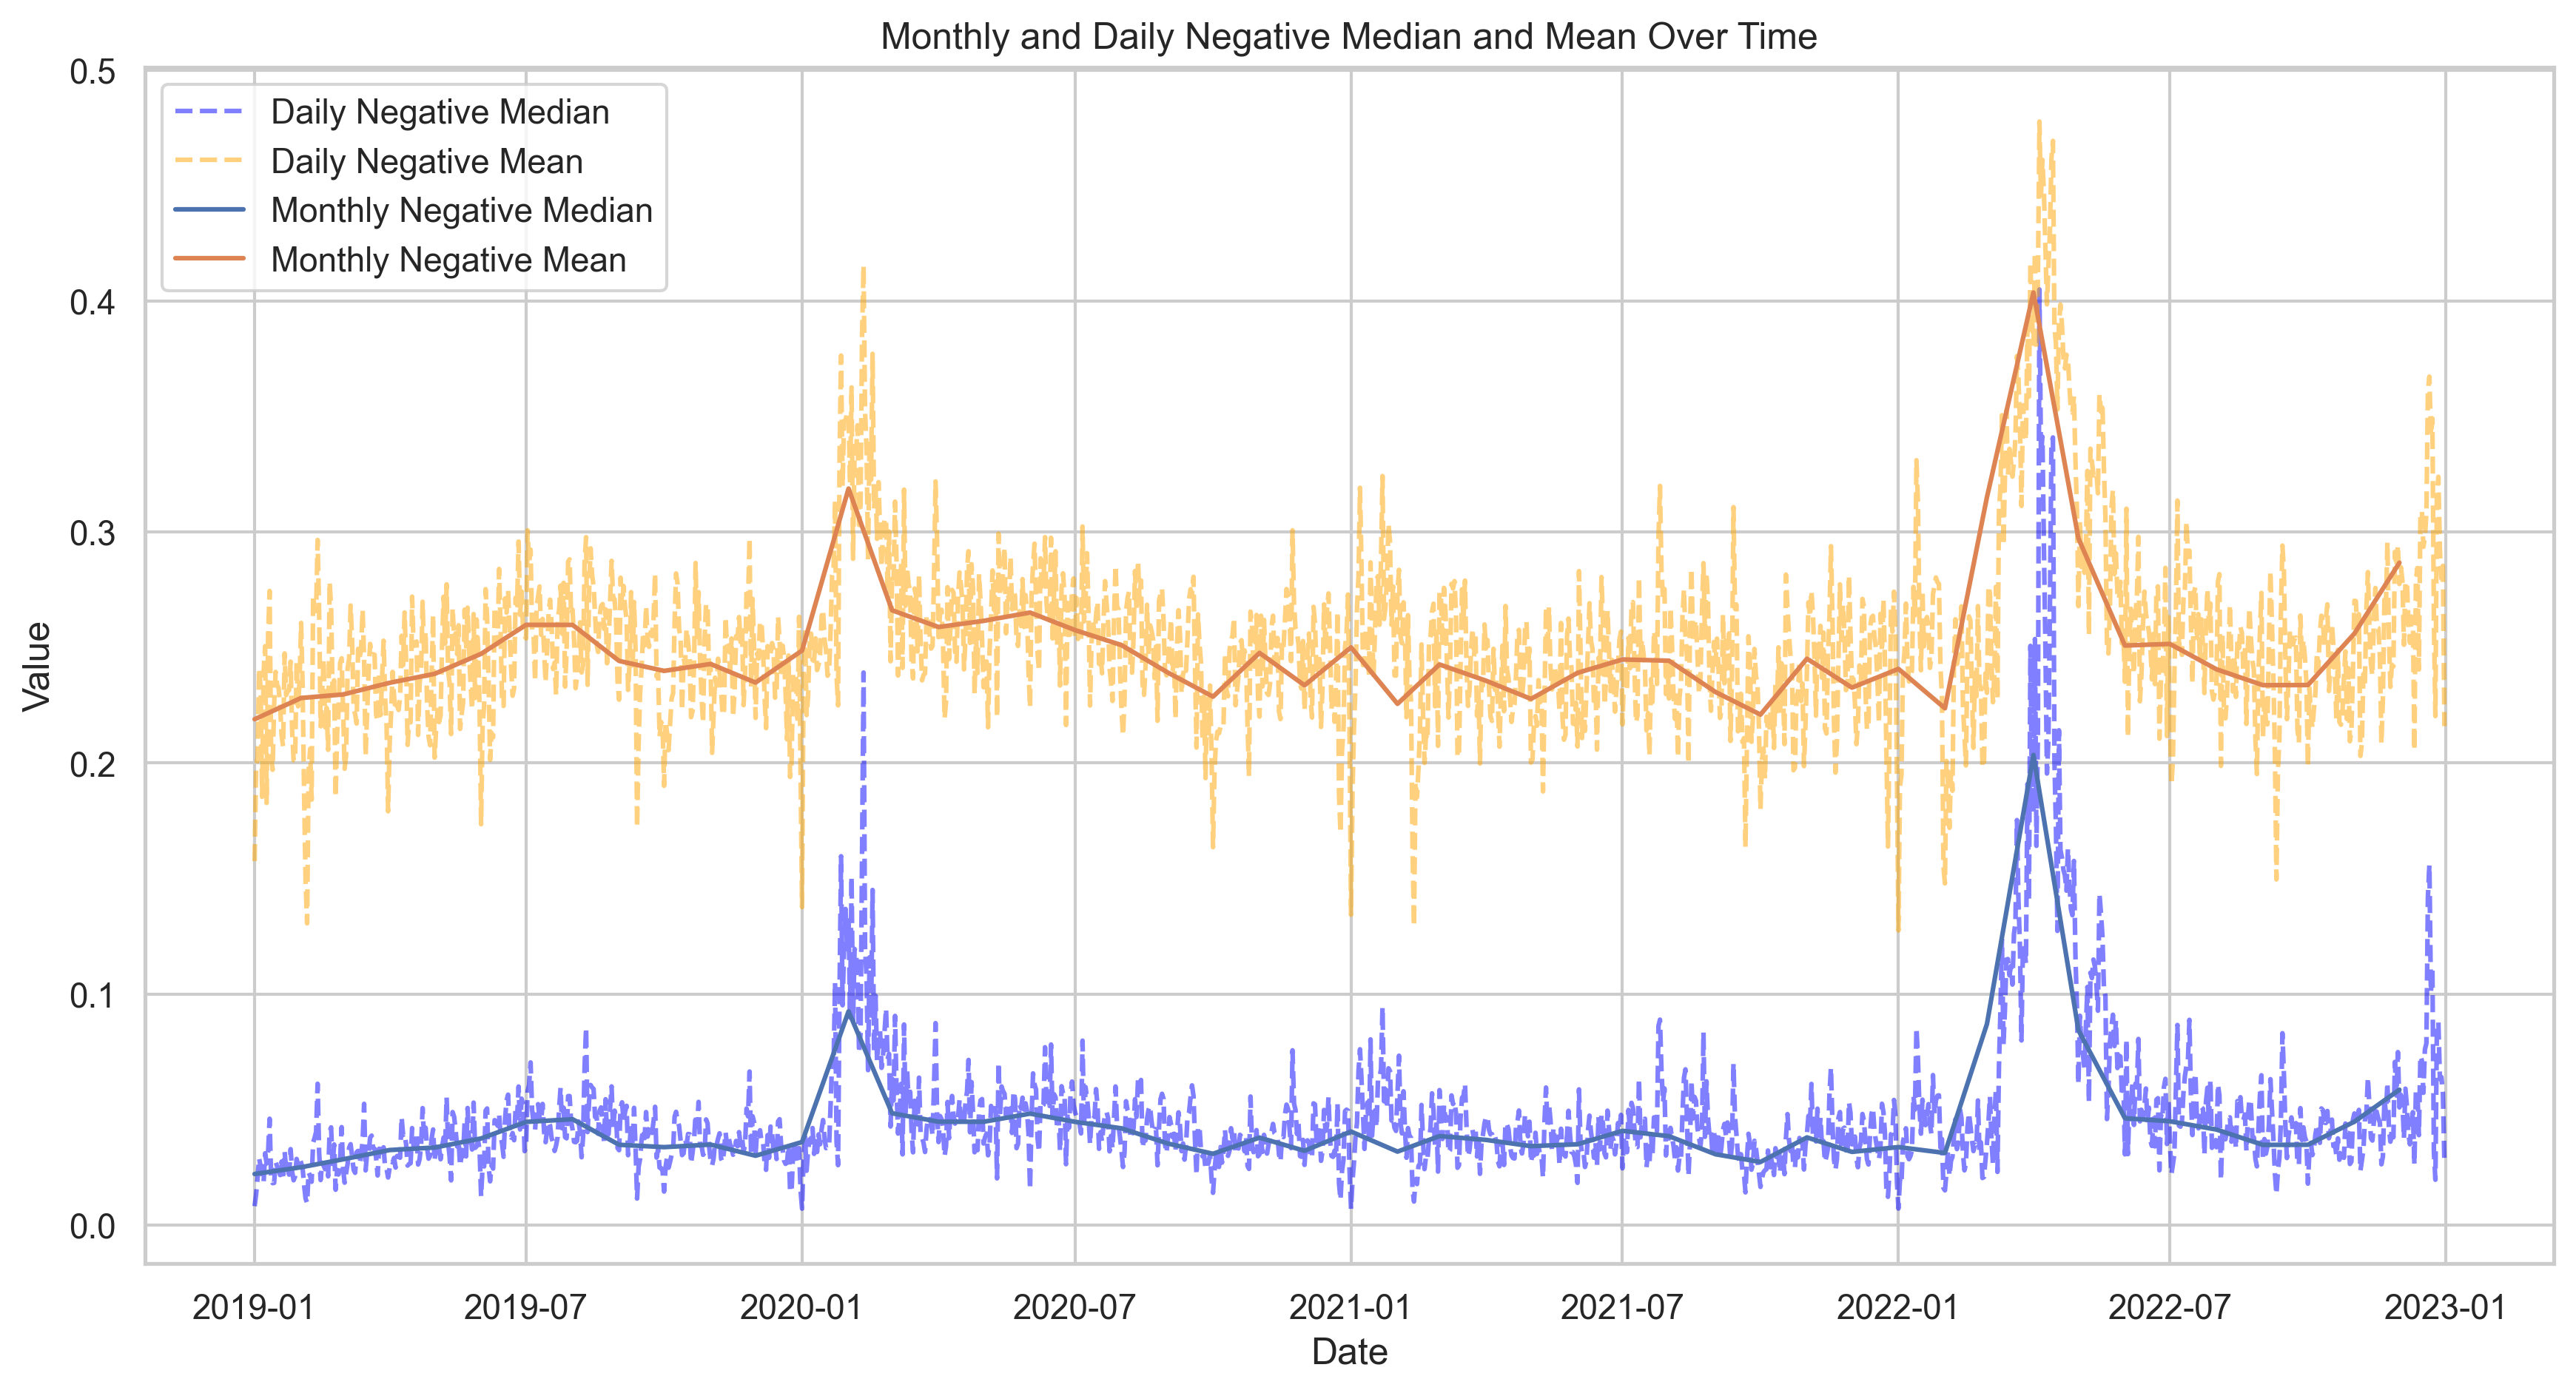

In [28]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob

# 指定文件夹路径
folder_path = r'data/上海2019_2023年按月分类文件_情绪值'

# 存储所有数据
all_data = []

# 使用glob模块遍历文件夹中的所有csv文件
for file_path in glob.glob(os.path.join(folder_path, '*.csv')):
    try:
        data = pd.read_csv(file_path)
        data=data[['publish_time','baidu_confidence','baidu_negative','baidu_positive','baidu_sentiment']]
        data['publish_time']=pd.to_datetime(data['publish_time'], infer_datetime_format=True)
        all_data.append(data)
    except Exception as e:
        print(f"Error reading file {file_path}: {e}")

# 合并所有数据
df = pd.concat(all_data, ignore_index=True)

# 按日分组，计算每日negaive值的中位数和平均数
daily_stats = df.groupby(df['publish_time'].dt.date).agg({
    'baidu_negative': ['median', 'mean']
}).reset_index()

# 重命名列以便于后续处理
daily_stats.columns = ['date', 'negative_median_daily', 'negative_mean_daily']

# 将日期列转换为datetime格式
daily_stats['date'] = pd.to_datetime(daily_stats['date'])

# 按月分组，计算每月negative值的中位数和平均数
monthly_stats = df.groupby(df['publish_time'].dt.to_period('M').dt.to_timestamp()).agg({
    'baidu_negative': ['median', 'mean']
}).reset_index()

# 重命名列以便于后续处理
monthly_stats.columns = ['date', 'negative_median_monthly', 'negative_mean_monthly']

# 将日期列转换为datetime格式
monthly_stats['date'] = pd.to_datetime(monthly_stats['date'])

# 设置seaborn风格
sns.set(style="whitegrid")

# 绘制图表
plt.figure(figsize=(14, 7), dpi=300)

# 绘制按日计算的中位数曲线（虚线）
sns.lineplot(x='date', y='negative_median_daily', data=daily_stats, linestyle='--', color='blue', label='Daily Negative Median',alpha=0.5)

# 绘制按日计算的平均数曲线（虚线）
sns.lineplot(x='date', y='negative_mean_daily', data=daily_stats, linestyle='--', color='orange', label='Daily Negative Mean',alpha=0.5)

# 绘制按月计算的中位数曲线（实线）
sns.lineplot(x='date', y='negative_median_monthly', data=monthly_stats, label='Monthly Negative Median')

# 绘制按月计算的平均数曲线（实线）
sns.lineplot(x='date', y='negative_mean_monthly', data=monthly_stats, label='Monthly Negative Mean')



# 设置图表标题和标签
plt.title('Monthly and Daily Negative Median and Mean Over Time')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()

# 显示图表
plt.show()

daily_stats.to_csv('out/figure/Negative_daily_stats.csv', index=False,encoding='utf-8-sig')
monthly_stats.to_csv('out/figure/Negative_monthly_stats.csv', index=False,encoding='utf-8-sig')

一起

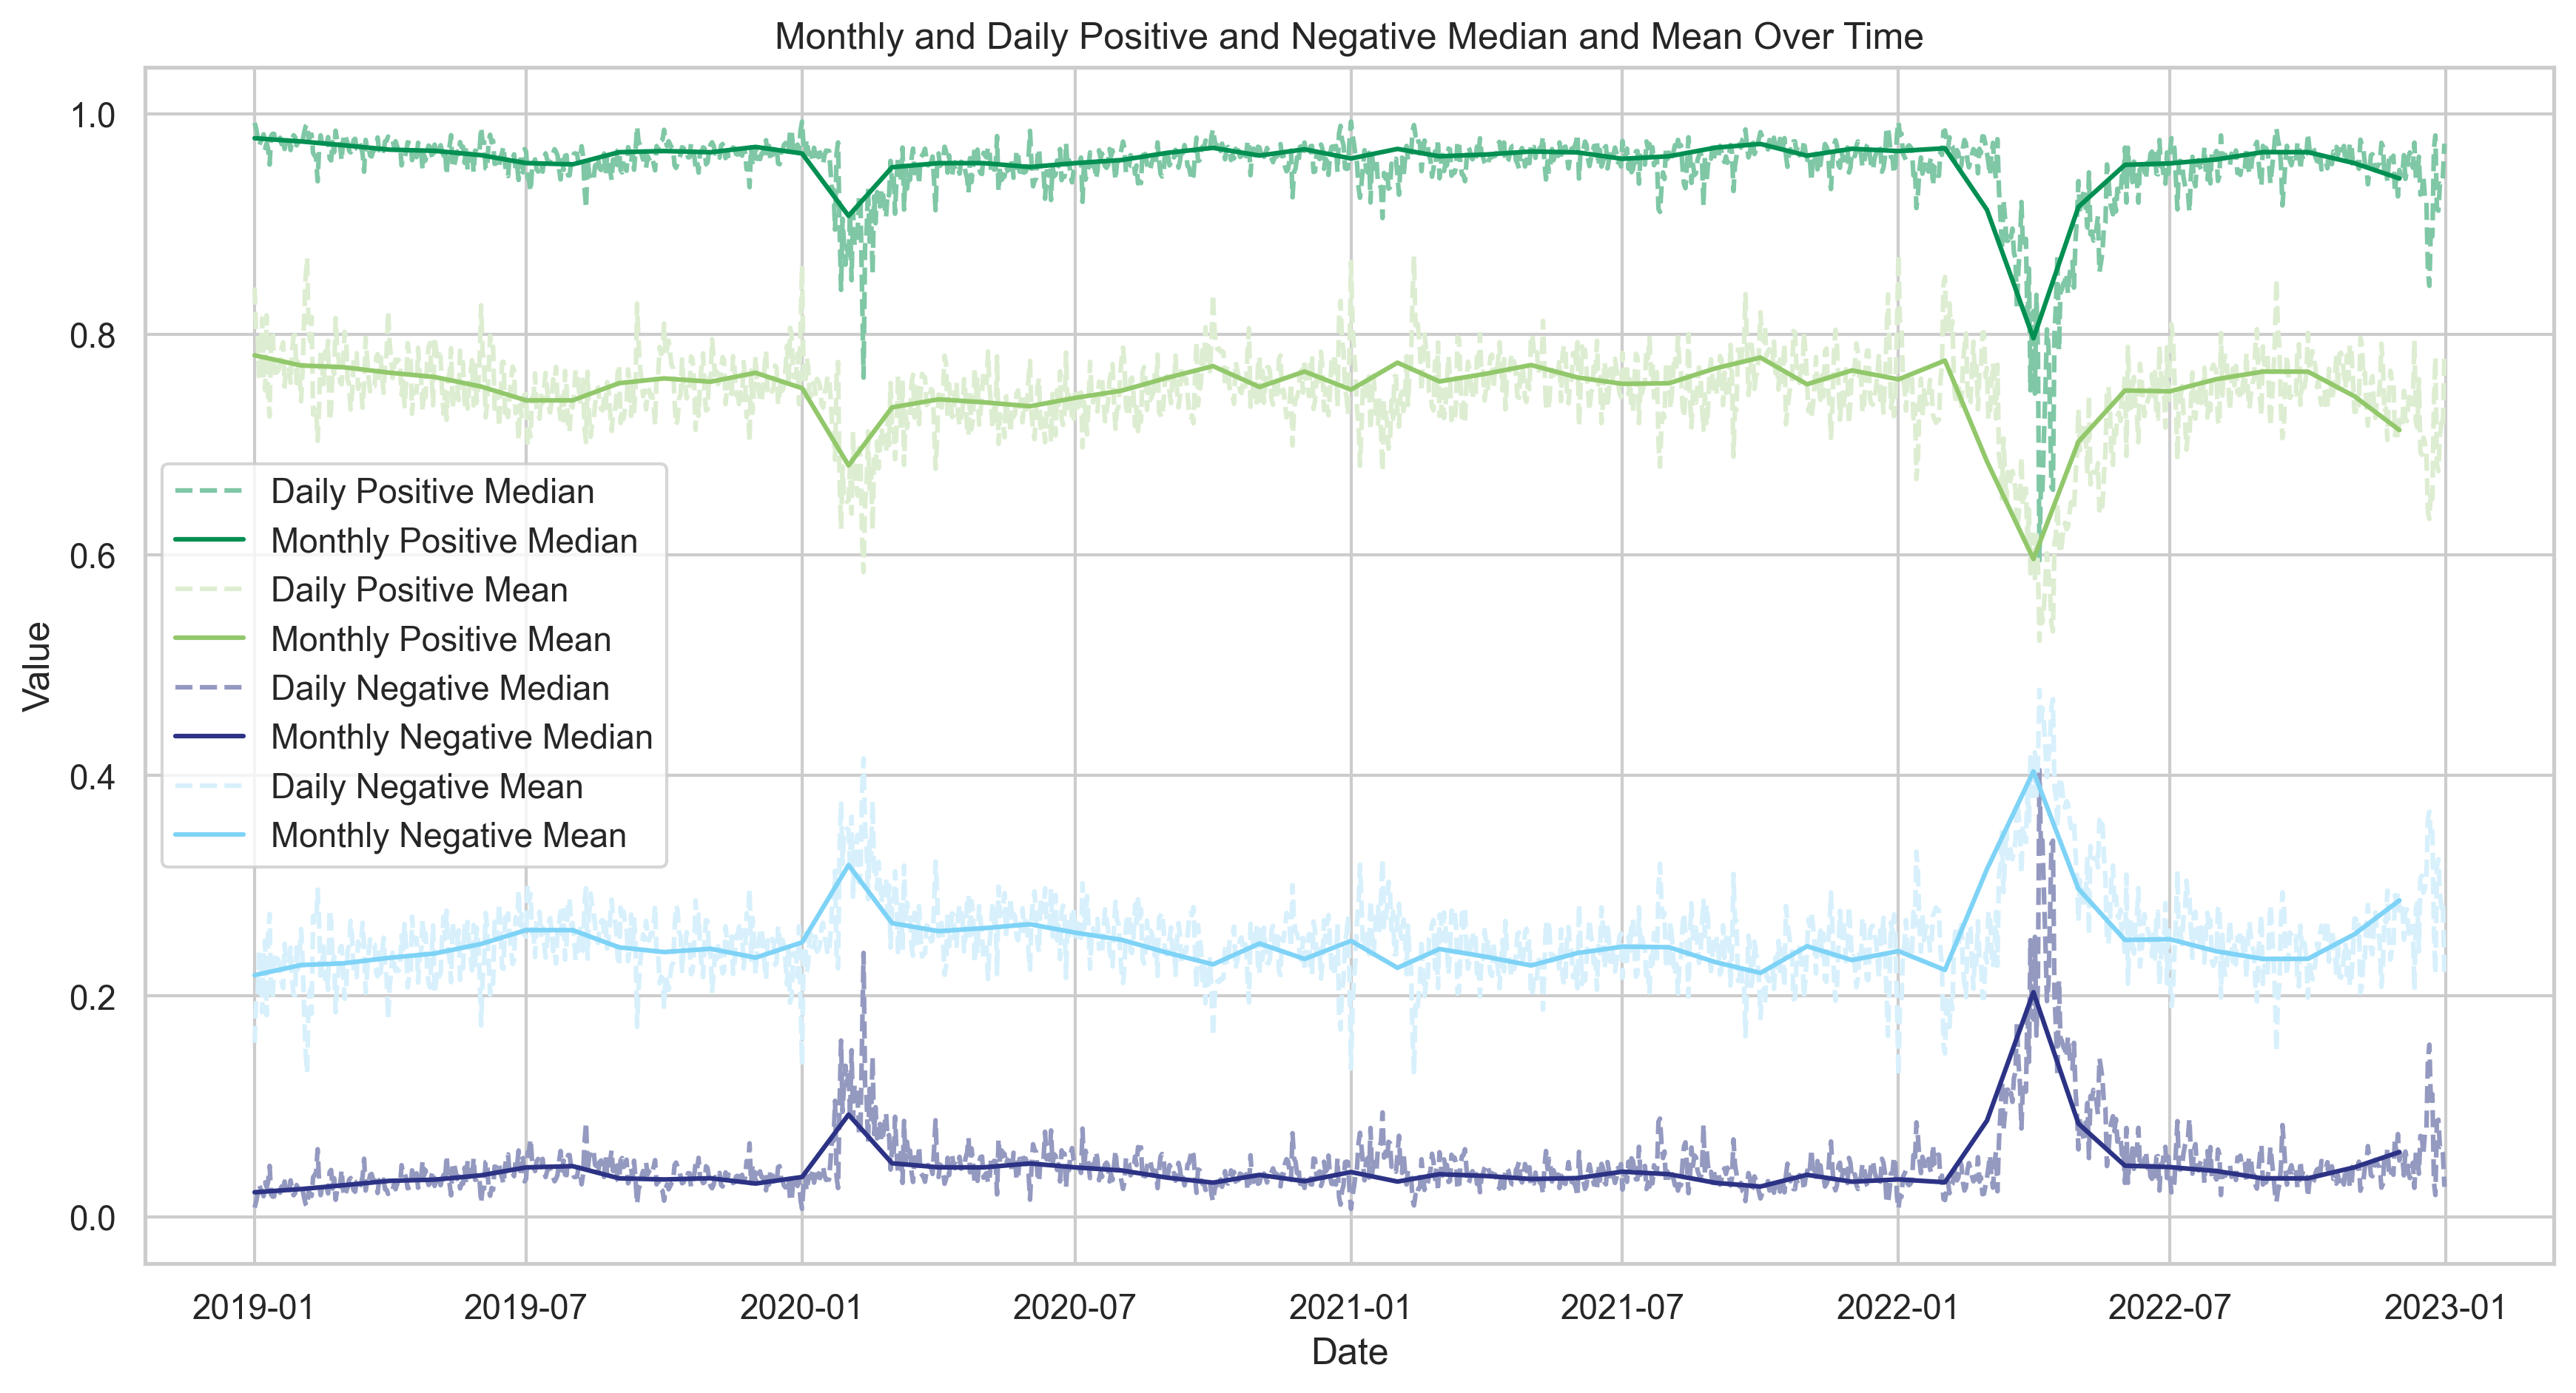

In [29]:
# 按日分组，计算每日positive值的中位数和平均数
daily_stats = df.groupby(df['publish_time'].dt.date).agg({
    'baidu_positive': ['median', 'mean']
}).reset_index()

# 重命名列以便于后续处理
daily_stats.columns = ['date', 'positive_median_daily', 'positive_mean_daily']

# 将日期列转换为datetime格式
daily_stats['date'] = pd.to_datetime(daily_stats['date'])

# 按月分组，计算每月positive值的中位数和平均数
monthly_stats = df.groupby(df['publish_time'].dt.to_period('M').dt.to_timestamp()).agg({
    'baidu_positive': ['median', 'mean']
}).reset_index()

# 重命名列以便于后续处理
monthly_stats.columns = ['date', 'positive_median_monthly', 'positive_mean_monthly']

# 将日期列转换为datetime格式
monthly_stats['date'] = pd.to_datetime(monthly_stats['date'])

# 设置seaborn风格
sns.set(style="whitegrid")

# 绘制图表
plt.figure(figsize=(14, 7), dpi=300)

# 绘制按日计算的中位数曲线（虚线）
sns.lineplot(x='date', y='positive_median_daily', data=daily_stats, linestyle='--', color='#7fc7a5', label='Daily Positive Median')
# 绘制按月计算的中位数曲线（实线）
# sns.lineplot(x='date', y='positive_median_monthly', data=monthly_stats, label='Monthly Positive Median', marker='o')
sns.lineplot(x='date', y='positive_median_monthly', data=monthly_stats, color='#018f52',label='Monthly Positive Median')

# 绘制按日计算的平均数曲线（虚线）
sns.lineplot(x='date', y='positive_mean_daily', data=daily_stats, linestyle='--', color='#ddedd1', label='Daily Positive Mean')
# 绘制按月计算的平均数曲线（实线）
# sns.lineplot(x='date', y='positive_mean_monthly', data=monthly_stats, label='Monthly Positive Mean', marker='x')
sns.lineplot(x='date', y='positive_mean_monthly', data=monthly_stats, color='#92c86b',label='Monthly Positive Mean')



# 按日分组，计算每日negaive值的中位数和平均数
daily_stats = df.groupby(df['publish_time'].dt.date).agg({
    'baidu_negative': ['median', 'mean']
}).reset_index()

# 重命名列以便于后续处理
daily_stats.columns = ['date', 'negative_median_daily', 'negative_mean_daily']

# 将日期列转换为datetime格式
daily_stats['date'] = pd.to_datetime(daily_stats['date'])

# 按月分组，计算每月negative值的中位数和平均数
monthly_stats = df.groupby(df['publish_time'].dt.to_period('M').dt.to_timestamp()).agg({
    'baidu_negative': ['median', 'mean']
}).reset_index()

# 重命名列以便于后续处理
monthly_stats.columns = ['date', 'negative_median_monthly', 'negative_mean_monthly']

# 将日期列转换为datetime格式
monthly_stats['date'] = pd.to_datetime(monthly_stats['date'])

# 设置seaborn风格
sns.set(style="whitegrid")

# 绘制按日计算的中位数曲线（虚线）
sns.lineplot(x='date', y='negative_median_daily', data=daily_stats, linestyle='--', color='#9499c0', label='Daily Negative Median')
# 绘制按月计算的中位数曲线（实线）
sns.lineplot(x='date', y='negative_median_monthly', data=monthly_stats,color='#2c3385', label='Monthly Negative Median')

# 绘制按日计算的平均数曲线（虚线）
sns.lineplot(x='date', y='negative_mean_daily', data=daily_stats, linestyle='--', color='#d7f0fc', label='Daily Negative Mean')
# 绘制按月计算的平均数曲线（实线）
sns.lineplot(x='date', y='negative_mean_monthly', data=monthly_stats,color='#7ed3f6', label='Monthly Negative Mean')

# 设置图表标题和标签
plt.title('Monthly and Daily Positive and Negative Median and Mean Over Time')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()

# 显示图表
plt.show()

monthly改15天

C:\Users\name\AppData\Local\Temp\ipykernel_4180\530103380.py:21: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data['publish_time'] = pd.to_datetime(data['publish_time'], infer_datetime_format=True)
C:\Users\name\AppData\Local\Temp\ipykernel_4180\530103380.py:21: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data['publish_time'] = pd.to_datetime(data['publish_time'], infer_datetime_format=True)
C:\Users\name\AppData\Local\Temp\ipykernel_4180\530103380.py:21: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future ver

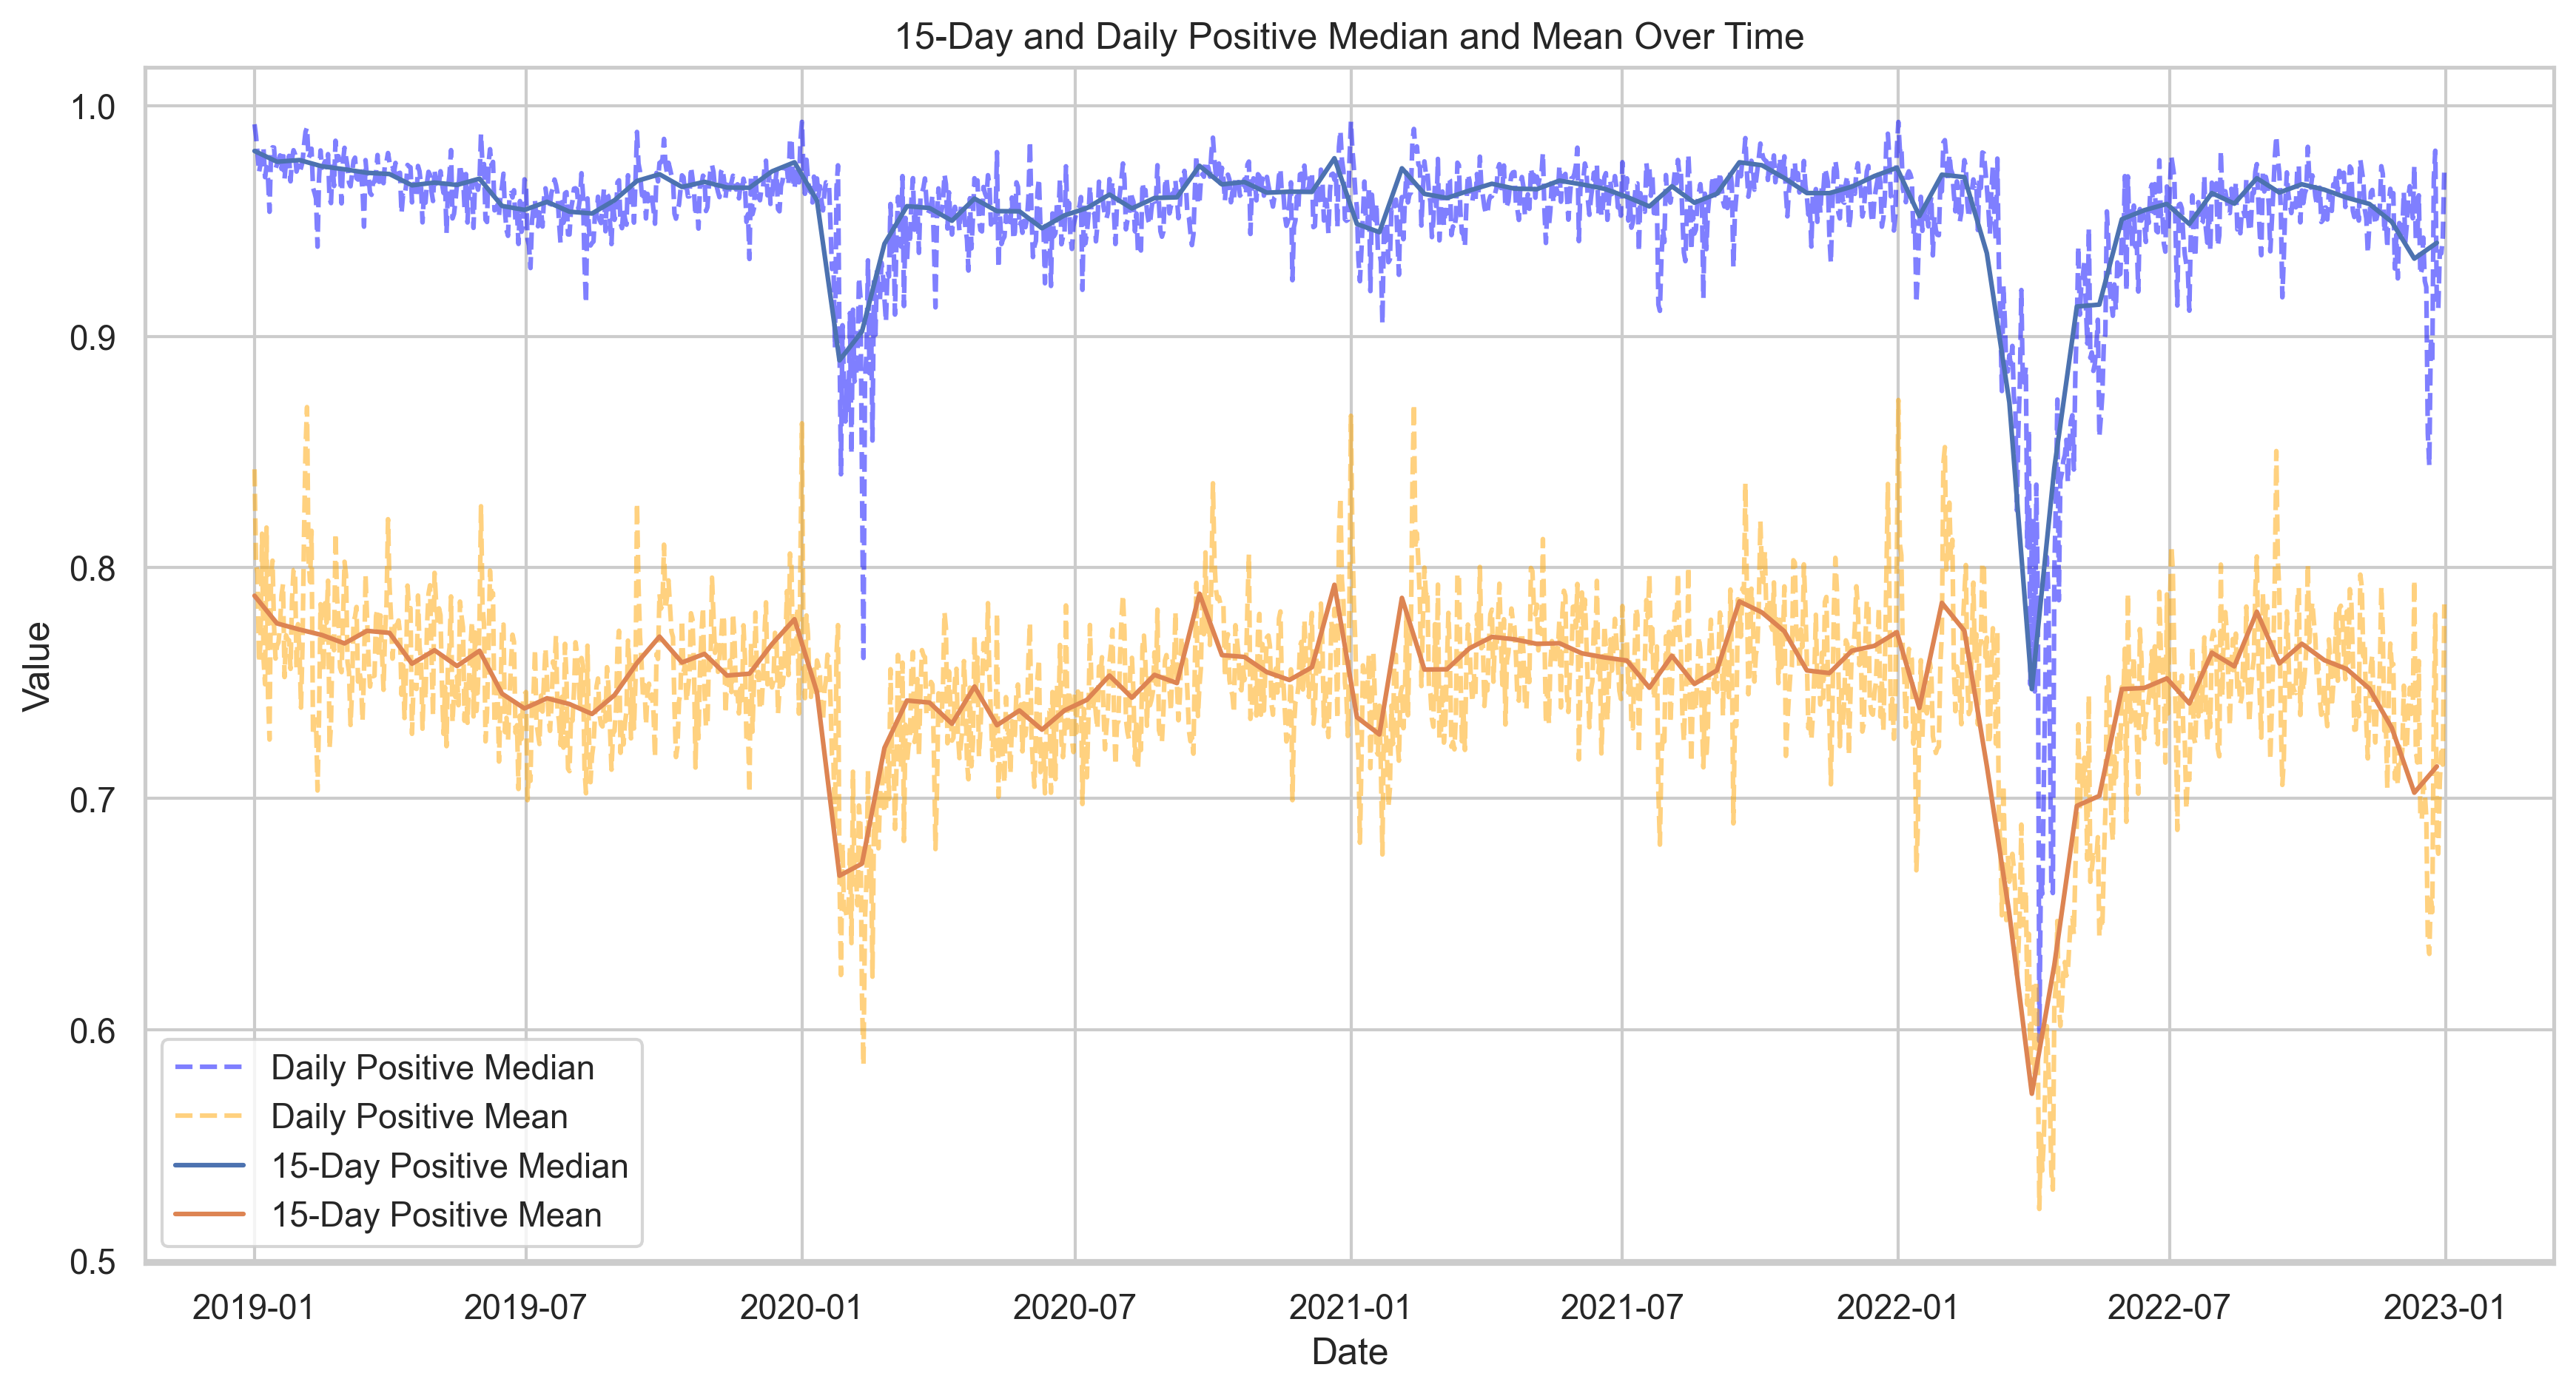

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob

# 使用nature的style
# plt.style.use('nature')

# 指定文件夹路径
folder_path = r'data/上海2019_2023年按月分类文件_情绪值'

# 存储所有数据
all_data = []

# 使用glob模块遍历文件夹中的所有csv文件
for file_path in glob.glob(os.path.join(folder_path, '*.csv')):
    try:
        data = pd.read_csv(file_path)
        data = data[['publish_time', 'baidu_confidence', 'baidu_negative', 'baidu_positive', 'baidu_sentiment']]
        data['publish_time'] = pd.to_datetime(data['publish_time'], infer_datetime_format=True)
        all_data.append(data)
    except Exception as e:
        print(f"Error reading file {file_path}: {e}")

# 合并所有数据
df = pd.concat(all_data, ignore_index=True)

# 按日分组，计算每日positive值的中位数和平均数
daily_stats = df.groupby(df['publish_time'].dt.date).agg({
    'baidu_positive': ['median', 'mean']
}).reset_index()

# 重命名列以便于后续处理
daily_stats.columns = ['date', 'positive_median_daily', 'positive_mean_daily']

# 将日期列转换为datetime格式
daily_stats['date'] = pd.to_datetime(daily_stats['date'])

# 按15天分组，计算每15天positive值的中位数和平均数
fifteen_day_stats = df.groupby(pd.Grouper(key='publish_time', freq='15D')).agg({
    'baidu_positive': ['median', 'mean']
}).reset_index()

# 重命名列以便于后续处理
fifteen_day_stats.columns = ['date', 'positive_median_fifteen_day', 'positive_mean_fifteen_day']

# 将日期列转换为datetime格式
fifteen_day_stats['date'] = pd.to_datetime(fifteen_day_stats['date'])

# 设置seaborn风格
sns.set(style="whitegrid")

# 绘制图表
plt.figure(figsize=(14, 7), dpi=300)

# 绘制按日计算的中位数曲线（虚线）
sns.lineplot(x='date', y='positive_median_daily', data=daily_stats, linestyle='--', color='blue', label='Daily Positive Median')

# 绘制按日计算的平均数曲线（虚线）
sns.lineplot(x='date', y='positive_mean_daily', data=daily_stats, linestyle='--', color='orange', label='Daily Positive Mean')

# 绘制按15天计算的中位数曲线（实线）
sns.lineplot(x='date', y='positive_median_fifteen_day', data=fifteen_day_stats, label='15-Day Positive Median')

# 绘制按15天计算的平均数曲线（实线）
sns.lineplot(x='date', y='positive_mean_fifteen_day', data=fifteen_day_stats, label='15-Day Positive Mean')

# 设置图表标题和标签
plt.title('15-Day and Daily Positive Median and Mean Over Time')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()

# 显示图表
plt.show()

# daily_stats.to_csv('out/figure/Positive_daily_stats.csv', index=False, encoding='utf-8-sig')
fifteen_day_stats.to_csv('out/figure/Positive_fifteen_day_stats.csv', index=False, encoding='utf-8-sig')
